In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import lime
import lime.lime_tabular
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lime import submodular_pick
from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import train_test_validation
sns.set_theme()

deepchecks - WARNING - You are using deepchecks version 0.14.0, however a newer version is available.Deepchecks is frequently updated with major improvements. You should consider upgrading via the "python -m pip install --upgrade deepchecks" command.


In [2]:
def plots_hist_box(column_name):
    sns.boxplot(x=spotify_data[column_name])
    sns.displot(spotify_data, x=column_name)

In [3]:
def whiskers_length(column_name):
    q1 = spotify_data[column_name].quantile(0.25)
    q3 = spotify_data[column_name].quantile(0.75)
    diff = q3 - q1
    lower_limit = q1 - 1.5*diff
    upper_limit = q3 + 1.5*diff
    return lower_limit,upper_limit

In [4]:
def dropping_outliers(column_name, lower_limit, upper_limit):
    drop = spotify_data[(spotify_data[column_name]>upper_limit)|(spotify_data[column_name]<lower_limit)]
    drop_idx = drop.index
    spotify_data.drop(axis=0,labels=drop_idx, inplace=True)

In [5]:
spotify_data = pd.read_csv("new_spotify_data.csv")
spotify_data.index.name='idx'
spotify_data.drop(axis=1,columns='Unnamed: 0', inplace=True)

In [6]:
spotify_data.shape

(41099, 20)

In [7]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41099 entries, 0 to 41098
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             41099 non-null  object 
 1   artist            41099 non-null  object 
 2   uri               41099 non-null  object 
 3   danceability      41099 non-null  float64
 4   energy            41099 non-null  float64
 5   key               41095 non-null  float64
 6   loudness          41099 non-null  float64
 7   mode              41099 non-null  int64  
 8   speechiness       41099 non-null  float64
 9   acousticness      41099 non-null  float64
 10  instrumentalness  41099 non-null  float64
 11  liveness          41099 non-null  float64
 12  valence           41099 non-null  float64
 13  tempo             41099 non-null  float64
 14  duration_ms       41098 non-null  float64
 15  time_signature    41099 non-null  int64  
 16  chorus_hit        41099 non-null  float6

Analizując typy kolumn, widać, że znaczna większość z nich jest reprezentowana przez liczby rzeczywiste lub całkowite. Pierwsze trzy kolumny, czyli track, artist oraz uri nie będę przekazywane jako dane wejściowe do modelu, więc nie musimy się nimi zajmować. Natomiast kolumna decade, która może być istotną przy budowaniu modelu, będzie musiała zostać zmodyfikowana tak, by dane kategoryczne które są w niej zawarte, zostały zamienione na dane numeryczne.

In [8]:
spotify_data.head(20)

track                artist  \
idx                                                                         
0                             Jealous Kind Of Fella         Garland Green   
1                                     Initials B.B.      Serge Gainsbourg   
2                                      Melody Twist           Lord Melody   
3                                     Mi Bomba Sonó            Celia Cruz   
4                                       Uravu Solla           P. Susheela   
5                                         Beat n. 3       Ennio Morricone   
6             Samba De Uma Nota So (One Note Samba)  Antônio Carlos Jobim   
7                                        Happy Days          Marv Johnson   
8                        Carolina - Remastered 2006        Caetano Veloso   
9                                  I Can Hear Music        The Beach Boys   
10                The Aftermath (From "Stagecoach")       Jerry Goldsmith   
11                                        Ride Away           Roy Orbison   
12                               Caboclo Nordestino          Luiz Gonzaga   
13                                         P.T. 109            Jimmy Dean   
14                                     Bye Bye Baby            Mary Wells   
15                         A Festa dos Seus 15 Anos                  Leño   
16                                    My Empty Arms         Jackie Wilson   
17                       Alfômega - Remastered 2006        Caetano Veloso   
18   Parsifal: "Wehevolles Erbe, dem ich verfallen"  Staatskapelle Berlin   
19                          Let The Good Times Roll         Shirley & Lee   

                                      uri  danceability  energy   key  \
idx                                                                     
0    spotify:track:1dtKN6wwlolkM8XZy2y9C1         0.417  0.6200   3.0   
1    spotify:track:5hjsmSnUefdUqzsDogisiX         0.498  0.5050   3.0   
2    spotify:track:6uk8tI6pwxxdVTNlNOJeJh         0.657  0.6490   5.0   
3    spotify:track:7aNjMJ05FvUXACPWZ7yJmv         0.590  0.5450   NaN   
4    spotify:track:1rQ0clvgkzWr001POOPJWx         0.515  0.7650  11.0   
5    spotify:track:32VBSoD2vcoIOiPEvAfFXU         0.697  0.6730   0.0   
6    spotify:track:62eoocmGk59EMfuRcLBvUL         0.662  0.2720   0.0   
7    spotify:track:0ecGwZA1ReAq4Mn3ZInaT4         0.720  0.6240   5.0   
8    spotify:track:15gNqKkZN9Mq9AvnRqWJKb         0.545  0.2200   2.0   
9    spotify:track:1hcMfYTsRTC4hIKbfosxjz         0.511  0.6030   2.0   
10   spotify:track:6Rt6SJijLoLxTYwGX73JMQ         0.491  0.0675  10.0   
11   spotify:track:1nxSCulSg5AtmExqgHPPC0         0.520  0.4110   9.0   
12   spotify:track:1IFkSZaIT1j6O4GO6N3Pqd         0.717  0.5650   2.0   
13   spotify:track:3vfNUZeVUiwWXwsEXjagqL         0.746  0.6660   2.0   
14   spotify:track:4HnfN3T1gJ88zmHiafIYcW         0.598  0.4480   4.0   
15   spotify:track:6ON2VernjxCS5z6lHdoGFl         0.521  0.3960   5.0   
16   spotify:track:7CHmNiReghVLKbD032HHwz         0.356  0.4500   6.0   
17   spotify:track:4DEodNc5zttV2UGiKMqtGw         0.493  0.6660  11.0   
18   spotify:track:1NI44QQk2rKTSOqrm6eT0Q         0.147  0.2460   1.0   
19   spotify:track:2ePDfIXoP2HmC1hfsujb2J         0.502  0.4450   1.0   

     loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
idx                                                                          
0      -7.727     1       0.0403        0.4900          0.000000    0.0779   
1     -12.475     1       0.0337        0.0180          0.107000    0.1760   
2     -13.392     1       0.0380        0.8460          0.000004    0.1190   
3     -12.058     0       0.1040        0.7060          0.024600    0.0610   
4      -3.515     0       0.1240        0.8570          0.000872    0.2130   
5     -10.573     1       0.0266        0.7140          0.919000    0.1220   
6     -18.883     1       0.0313        0.3600          0.228000    0.0963   
7      -9.086     0       0.0473        0.

In [9]:
spotify_data.tail(20)

track                         artist  \
idx                                                                        
41079          Metal Blessing (Live 2002)                  Mortification   
41080    Trash - The London Suede Version               The London Suede   
41081                    Dark Necessities          Red Hot Chili Peppers   
41082                                Cake          Flo Rida & 99 Percent   
41083  E Lucevan Le Stelle - Instrumental  Mělník Philharmonic Orchestra   
41084                               Shame                   Mikkel Metal   
41085        Gimme D' Road - Carnival Mix                   Calypso Rose   
41086                               Death  Trippie Redd Featuring DaBaby   
41087                        Vast Changes                       Regentum   
41088                            Kinfolks                       Sam Hunt   
41089                     Strip That Down     Liam Payne Featuring Quavo   
41090                            What Now                        Rihanna   
41091                    Tear In My Heart              twenty one pilots   
41092                     Sweater Weather              The Neighbourhood   
41093                         Untouchable     YoungBoy Never Broke Again   
41094                       Lotus Flowers                          Yolta   
41095                   Calling My Spirit                    Kodak Black   
41096                       Teenage Dream                     Katy Perry   
41097                      Stormy Weather                 Oscar Peterson   
41098                                Dust                    Hans Zimmer   

                                        uri  danceability  energy   key  \
idx                                                                       
41079  spotify:track:0Y0L0JE5HiTAKyWSkKusb7        0.2710   0.982   7.0   
41080  spotify:track:47VqgHgXvn4Cx2RVeQq2Tk        0.4390   0.993  11.0   
41081  spotify:track:2oaK4JLVnmRGIO9ytBE1bt        0.7000   0.742   5.0   
41082  spotify:track:6t2ubAB4iSYOuIpRAOGd4t        0.7860   0.854   2.0   
41083  spotify:track:2QDp4b9Gjk9FxpklHEoVIy        0.0934   0.188  10.0   
41084  spotify:track:3s3P5T211ogp5zXDnsGmgS        0.2970   0.410   4.0   
41085  spotify:track:6Yk1qYbmPKdoqNrHYRFc9c        0.3950   0.927   4.0   
41086  spotify:track:6YfTl5YupXOQBKiJJLrxcw        0.8020   0.820  10.0   
41087  spotify:track:6RSamYe6vPBz7mGHe5Qj1q        0.3960   0.044   9.0   
41088  spotify:track:53F1MVa1BWUkTBbVqgVAfN        0.5650   0.805   0.0   
41089  spotify:track:4Ro98RCK90oHqqSZUnTFq5        0.8740   0.497   6.0   
41090  spotify:track:0aUWfpD3PlSv3FTTKcT2rN        0.4020   0.696   8.0   
41091  spotify:track:3bnVBN67NBEzedqQuWrpP4        0.6550   0.632   2.0   
41092  spotify:track:2QjOHCTQ1Jl3zawyYOpxh6        0.6120   0.807  10.0   
41093  spotify:track:4MofYf0f4ijlVV6elUW5S3        0.7800   0.784   1.0   
41094  spotify:track:4t1TljQWJ6ZuoSY67zVvBI        0.1720   0.358   9.0   
41095  spotify:track:2MShy1GSSgbmGUxADNIao5        0.9100   0.366   1.0   
41096  spotify:track:55qBw1900pZKfXJ6Q9A2Lc        0.7190   0.804  10.0   
41097  spotify:track:4o9npmYHrOF1rUxxTVH8h4        0.6000   0.177   7.0   
41098  spotify:track:2khIaVUkbMmDHB596lyMG3        0.1210   0.123   4.0   

       loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
idx                                                                            
41079    -4.295     1       0.1210      0.000258          0.004530    0.5860   
41080    -2.923     1       0.1000      0.000937          0.000063    0.2850   
41081    -6.777     0       0.0716      0.072200          0.019900    0.1100   
41082    -4.247     1       0.0523      0.072900          0.000002    0.1790   
41083   -16.340     0       0.0399      0.940000          0.903000    0.1160   
41084   -16.100     0       0.0368      0.273000          0.942000    0.0947   
41085    -4.418     1       0.1650      0.116000          0.000000    0.

In [94]:
count = (spotify_data['mode'] == 0).sum()
count

12446

# Przygotowanie dancyh

### Braki danych

Przed rozpoczęciem pracy z danymi upewniamy się, iż nie ma w zbiorze braków danych oraz każdy z rekordów jest unikalny. W tym celu najpierw użyte zostaną funkcje isna oraz sum, na każdej z kolumn, aby zliczyć braki danych w każdej z nich. Następnie za pomocą funkcji duplicated, biorąc pod uwagę tylko kolumnę uri, która gwarantuje niepowatarzalność wierszy, sprawdzona zostanie ich unikalność.

In [10]:
spotify_data.isna().sum()

track               0
artist              0
uri                 0
danceability        0
energy              0
key                 4
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         1
time_signature      0
chorus_hit          0
sections            0
popularity          0
decade              0
dtype: int64

Dwie z kolumn zawierają wartości rózne od zera, co ozanacza, że mamy w nich braki danych. Są to kolumny key i duration_ms. W celu pozbycia się braków możemy usunąć rekord albo uzupełnić go zerem lub wartością powstałą z danych, które posiadamy. 

In [11]:
spotify_data[spotify_data['key'].isna()]

track         artist                                   uri  \
idx                                                                          
3       Mi Bomba Sonó     Celia Cruz  spotify:track:7aNjMJ05FvUXACPWZ7yJmv   
7609   If I Can Dream  Elvis Presley  spotify:track:6L0bHTV6hf9UL6uCezlJCC   
25001   Rottin' Apple     Strung Out  spotify:track:6EEHNQbpaMGdEtrwmM62tk   
39071   Kill the Cult    Decapitated  spotify:track:62STKumWqTi2gxwpgWOXZz   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
idx                                                                           
3             0.590   0.545  NaN   -12.058     0       0.1040      0.706000   
7609          0.182   0.828  NaN    -7.278     1       0.0806      0.003560   
25001         0.269   0.934  NaN    -5.462     1       0.0717      0.000225   
39071         0.432   0.990  NaN    -4.870     1       0.0839      0.000076   

       instrumentalness  liveness  valence    tempo  duration_ms  \
idx                                                                
3               0.02460    0.0610    0.967  105.592     157907.0   
7609            0.00000    0.0546    0.427  187.937     190573.0   
25001           0.00178    0.0683    0.467  104.608     149173.0   
39071           0.01900    0.3020    0.216   93.955     280253.0   

       time_signature  chorus_hit  sections  popularity decade  
idx                                                             
3                   4    24.75484         8           0    60s  
7609                3    34.19300         9           1    60s  
25001               4    19.38191         6           0    90s  
39071               4    60.31291        11           0    10s

Poza brakami wratości w kolumnmie key, pozostałe dane mieszczą się w normach. Aby wypełnić brakujące wartości skorzystamy z funkcji fillna()  i uzupełnimy je średnią wartością z kolumny, zaokrągloną do najbliżeszej wartości całkowitej.

In [12]:
mean = spotify_data['key'].mean().round()
spotify_data['key'].fillna(value=mean, inplace=True)

In [13]:
spotify_data[spotify_data['duration_ms'].isna()]

track       artist                                   uri  \
idx                                                                            
31321  Sentiment Nocturne  Misanthrope  spotify:track:3XBlvx2k5YACN47ICsAASQ   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
idx                                                                           
31321         0.448   0.973  2.0    -3.706     1       0.0798      0.000008   

       instrumentalness  liveness  valence    tempo  duration_ms  \
idx                                                                
31321             0.112    0.0514    0.427  120.092          NaN   

       time_signature  chorus_hit  sections  popularity decade  
idx                                                             
31321               4    62.56231        18           0    00s

W przypadku brakującej wartości w kolumnie duration_ms uzupełnimy ją wartośią poprzedzającą.

In [14]:
spotify_data['duration_ms'].fillna(method='ffill', inplace=True)

In [15]:
spotify_data.isna().sum()

track               0
artist              0
uri                 0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
popularity          0
decade              0
dtype: int64

### Duplikaty danych

Kolejnym etapem czyszenia danych jest przeszukanie zbioru w celu znalezienia duplikatów. W tym celu znajdziemy duplikaty w kolumnie uri której wartości jest unikalna dla każdego z utworów.

In [16]:
duplicated = spotify_data.duplicated(subset=['uri'])

In [17]:
spotify_data[duplicated]

track  \
idx                                                  
2191                                           You   
2649                                     Good News   
3555                        Days Of Wine And Roses   
3568                                          98.6   
4122                            4 - By The Beatles   
...                                            ...   
40838                                   White Liar   
40917  The Christmas Song (Merry Christmas To You)   
40930                             Gettin' Over You   
40988                                     Trumpets   
41001                                     Don't It   

                                                  artist  \
idx                                                        
2191                                         Marvin Gaye   
2649                                           Sam Cooke   
3555                                       Andy Williams   
3568                                               Keith   
4122                                         The Beatles   
...                                                  ...   
40838                                    Miranda Lambert   
40917                                      Nat King Cole   
40930  David Guetta & Chris Willis Featuring Fergie &...   
40988                                       Jason Derulo   
41001                                   Billy Currington   

                                        uri  danceability  energy   key  \
idx                                                                       
2191   spotify:track:2zF8ro2hX0aEYaqXQdEKW1         0.653   0.490   0.0   
2649   spotify:track:4UcxTnA6C5vCW79PIZ38Vx         0.663   0.638   2.0   
3555   spotify:track:3tvqPPpXyIgKrm4PR9HCf0         0.154   0.185   5.0   
3568   spotify:track:602FffJEffSJnWC8eHDIwv         0.542   0.335   7.0   
4122   spotify:track:4uKyLqJHDjT6mdA22ofxuM         0.527   0.522   0.0   
...                                     ...           ...     ...   ...   
40838  spotify:track:08NPIspzvBNj88lHalgA4V         0.350   0.777  10.0   
40917  spotify:track:4PS1e8f2LvuTFgUs1Cn3ON         0.319   0.210   1.0   
40930  spotify:track:6FbGlkHKGkYqpSCuBgurn3         0.620   0.870  10.0   
40988  spotify:track:5KONnBIQ9LqCxyeSPin26k         0.635   0.691   0.0   
41001  spotify:track:0iA1unTbTbDOWUSlbwJ1pS         0.558   0.818   8.0   

       loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
idx                                                                            
2191    -10.106     1       0.0408        0.3230          0.000004    0.0832   
2649     -8.765     1       0.0592        0.6910          0.000000    0.3020   
3555    -14.063     1       0.0315        0.9110          0.000267    0.1120   
3568    -10.291     1       0.0383        0.3800          0.000000    0.0828   
4122    -10.614     1       0.0259        0.7170          0.000595    0.1420   
...         ...   ...          ...           ...               ...       ...   
40838    -4.330     1       0.0336        0.0499          0.000742    0.4130   
40917   -15.231     1       0.0341        0.9200          0.000081    0.1380   
40930    -6.520     0       0.0868        0.1490          0.000000    0.0705   
40988    -4.862     1       0.2580        0.5550          0.000000    0.0970   
41001    -4.070     1       0.0403        0.0710          0.000000    0.2100   

       valence    tempo  duration_ms  time_signature  chorus_hit  sections  \
idx                                                                          
2191     0.963  110.202     177773.0               4    45.44257         8   
2649     0.869  119.479     146493.0               4    49.12307         7   
3555     0.150   83.969     166107.0               4    42.51415        10   
3568     0.504   74.524     187400.0               4    54.06921        10   
4122     0.730   85.155     305973.0               4    34.19988        13  

W zbiorze spotify_data znaleziono 546 dupikatów danych. Aby sprawdzić, czy na pewno rekordy są identyczne, sprawdzimy kilka losowych utworów.

In [18]:
spotify_data[spotify_data['uri']=='spotify:track:6FbGlkHKGkYqpSCuBgurn3']

track  \
idx                                              
34469  Gettin' Over You (feat. Fergie & LMFAO)   
40930                         Gettin' Over You   

                                                  artist  \
idx                                                        
34469                                       David Guetta   
40930  David Guetta & Chris Willis Featuring Fergie &...   

                                        uri  danceability  energy   key  \
idx                                                                       
34469  spotify:track:6FbGlkHKGkYqpSCuBgurn3          0.62    0.87  10.0   
40930  spotify:track:6FbGlkHKGkYqpSCuBgurn3          0.62    0.87  10.0   

       loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
idx                                                                            
34469     -6.52     0       0.0868         0.149               0.0    0.0705   
40930     -6.52     0       0.0868         0.149               0.0    0.0705   

       valence    tempo  duration_ms  time_signature  chorus_hit  sections  \
idx                                                                          
34469    0.513  130.079     187427.0               4    38.05592         9   
40930    0.513  130.079     187427.0               4    38.05592         9   

       popularity decade  
idx                       
34469           0    00s  
40930           1    10s

In [19]:
spotify_data[spotify_data['uri']=='spotify:track:08NPIspzvBNj88lHalgA4V']

track           artist                                   uri  \
idx                                                                        
34473  White Liar  Miranda Lambert  spotify:track:08NPIspzvBNj88lHalgA4V   
40838  White Liar  Miranda Lambert  spotify:track:08NPIspzvBNj88lHalgA4V   

       danceability  energy   key  loudness  mode  speechiness  acousticness  \
idx                                                                            
34473          0.35   0.777  10.0     -4.33     1       0.0336        0.0499   
40838          0.35   0.777  10.0     -4.33     1       0.0336        0.0499   

       instrumentalness  liveness  valence   tempo  duration_ms  \
idx                                                               
34473          0.000742     0.413    0.419  185.04     287760.0   
40838          0.000742     0.413    0.419  185.04     287760.0   

       time_signature  chorus_hit  sections  popularity decade  
idx                                                             
34473               4    32.37916        11           1    00s  
40838               4    32.37916        11           1    10s

In [20]:
spotify_data[spotify_data['uri']=='spotify:track:2zF8ro2hX0aEYaqXQdEKW1']

track       artist  \
idx                                                     
43    How Sweet It Is To Be Loved By You  Marvin Gaye   
2191                                 You  Marvin Gaye   

                                       uri  danceability  energy  key  \
idx                                                                     
43    spotify:track:2zF8ro2hX0aEYaqXQdEKW1         0.653    0.49  0.0   
2191  spotify:track:2zF8ro2hX0aEYaqXQdEKW1         0.653    0.49  0.0   

      loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
idx                                                                           
43     -10.106     1       0.0408         0.323          0.000004    0.0832   
2191   -10.106     1       0.0408         0.323          0.000004    0.0832   

      valence    tempo  duration_ms  time_signature  chorus_hit  sections  \
idx                                                                         
43      0.963  110.202     177773.0               4    45.44257         8   
2191    0.963  110.202     177773.0               4    45.44257         8   

      popularity decade  
idx                      
43             1    60s  
2191           1    60s

In [21]:
spotify_data[spotify_data['uri']=='spotify:track:602FffJEffSJnWC8eHDIwv']

track artist                                   uri  \
idx                                                                  
3287  Ain't Gonna Lie  Keith  spotify:track:602FffJEffSJnWC8eHDIwv   
3568             98.6  Keith  spotify:track:602FffJEffSJnWC8eHDIwv   

      danceability  energy  key  loudness  mode  speechiness  acousticness  \
idx                                                                          
3287         0.542   0.335  7.0   -10.291     1       0.0383          0.38   
3568         0.542   0.335  7.0   -10.291     1       0.0383          0.38   

      instrumentalness  liveness  valence   tempo  duration_ms  \
idx                                                              
3287               0.0    0.0828    0.504  74.524     187400.0   
3568               0.0    0.0828    0.504  74.524     187400.0   

      time_signature  chorus_hit  sections  popularity decade  
idx                                                            
3287               4    54.06921        10           1    60s  
3568               4    54.06921        10           1    60s

Analizując te cztery utwory, wpierwszej kolejności, w oczy rzuca się fakt, iż nazwy utworów, artyści go wykonujący, czy nawet dekady z których utwory pochodzą, różnią się. Jednak istotne jest to, iż w żadnej z pozostałych kolumn opisujących utwór, nie ma żadnych zmian. Takie zjawisko może być wynikiem, na przykład: ponownego nagrania utworu w późniejszym czasie, stworzenia nowej wersji utworu z artystami gościnnymi lub stworzenia coveru utworu przez innego artystę. Warto zauważyć, że jednak takie zmiany nie mają żadnego wpływu na sam utwór, przez co możemy uznać je za duplikaty danych i usunąc ze zbioru.

In [22]:
spotify_data = spotify_data.drop_duplicates(subset='uri', keep='first')

 ### Dane odstające

Nastpęnym krokiem, jest przyjrzenie się wartościom średnich, median, minimum oraz maksimum każdej z kolumn. Taki zabieg pozwoli nam na dokładniejsze przyjrzenie się danym oraz wyłapanie ewentualnych błędów w zbiorze.

In [23]:
spotify_data.describe()

danceability        energy           key      loudness          mode  \
count  40553.000000  40553.000000  40553.000000  40553.000000  40553.000000   
mean       0.538779      0.578631      5.213326    -10.247333      0.693019   
std        0.177894      0.253199      3.532867      5.326006      0.461247   
min        0.000000      0.000251      0.000000    -49.253000      0.000000   
25%        0.419000      0.394000      2.000000    -12.847000      0.000000   
50%        0.551000      0.600000      5.000000     -9.282000      1.000000   
75%        0.668000      0.787000      8.000000     -6.390000      1.000000   
max        0.988000      1.000000     11.000000      3.744000      1.000000   

        speechiness  acousticness  instrumentalness      liveness  \
count  40553.000000  40553.000000      40553.000000  40553.000000   
mean       0.072980      0.366758          0.156179      0.201769   
std        0.086178      0.355561          0.304878      0.173246   
min        0.000000     -3.200000          0.000000      0.013000   
25%        0.033700      0.039500          0.000000      0.094100   
50%        0.043500      0.261000          0.000126      0.132000   
75%        0.069900      0.680000          0.066100      0.262000   
max        0.960000     17.300000          1.000000      0.999000   

            valence         tempo   duration_ms  time_signature    chorus_hit  \
count  40553.000000  40553.000000  4.055300e+04    40553.000000  40553.000000   
mean       0.541601    119.323339  2.347352e+05        3.892782     40.134452   
std        0.267561     29.124096  1.195451e+05        0.424452     19.043957   
min        0.000000      0.000000  1.516800e+04        0.000000      0.000000   
25%        0.329000     97.338000  1.725330e+05        4.000000     27.615740   
50%        0.558000    117.520000  2.175600e+05        4.000000     35.853070   
75%        0.767000    136.532000  2.665730e+05        4.000000     47.664150   
max        0.996000    241.423000  4.170227e+06        5.000000    433.182000   

           sections    popularity  
count  40553.000000  40553.000000  
mean      10.470545      0.493478  
std        4.893901      0.499964  
min        0.000000      0.000000  
25%        8.000000      0.000000  
50%       10.000000      0.000000  
75%       12.000000      1.000000  
max      169.000000      1.000000

Porównując dane zebrane w tabeli oraz wiadomości na temat zakresu poszczególnych parametrów, widać że dane w kolumnie acousticness odbiegają od jej normy, gdyż powinny one być zawarte w przedziale [0-1]. Ponadto, kolumna loudness posiada dane dodatnie, podczas gdy powinny one być mniejsze lub równe 0. Pozostałe kolumny nie wzbudzają żadnych podejrzeń, jednak warto przyjrzeć się każdej z nich. W tym celu, za pomocą biblioteli sweetviz wygeneorwany zostanie raport podsumowujący każdą z kolumn.

In [24]:
spotify_report = sv.analyze(spotify_data)

                                             |      | [  0%]   00:00 -> (? left)


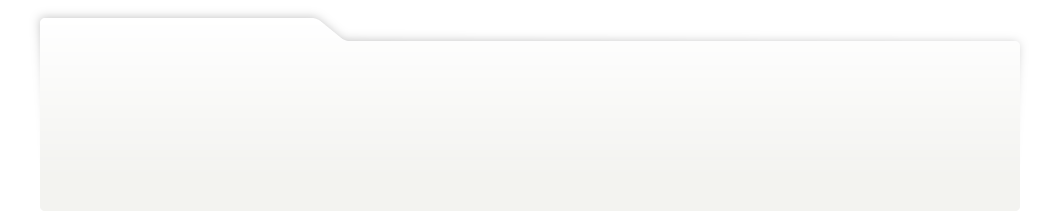
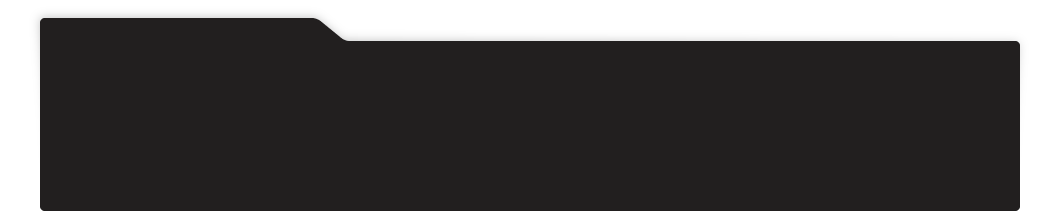
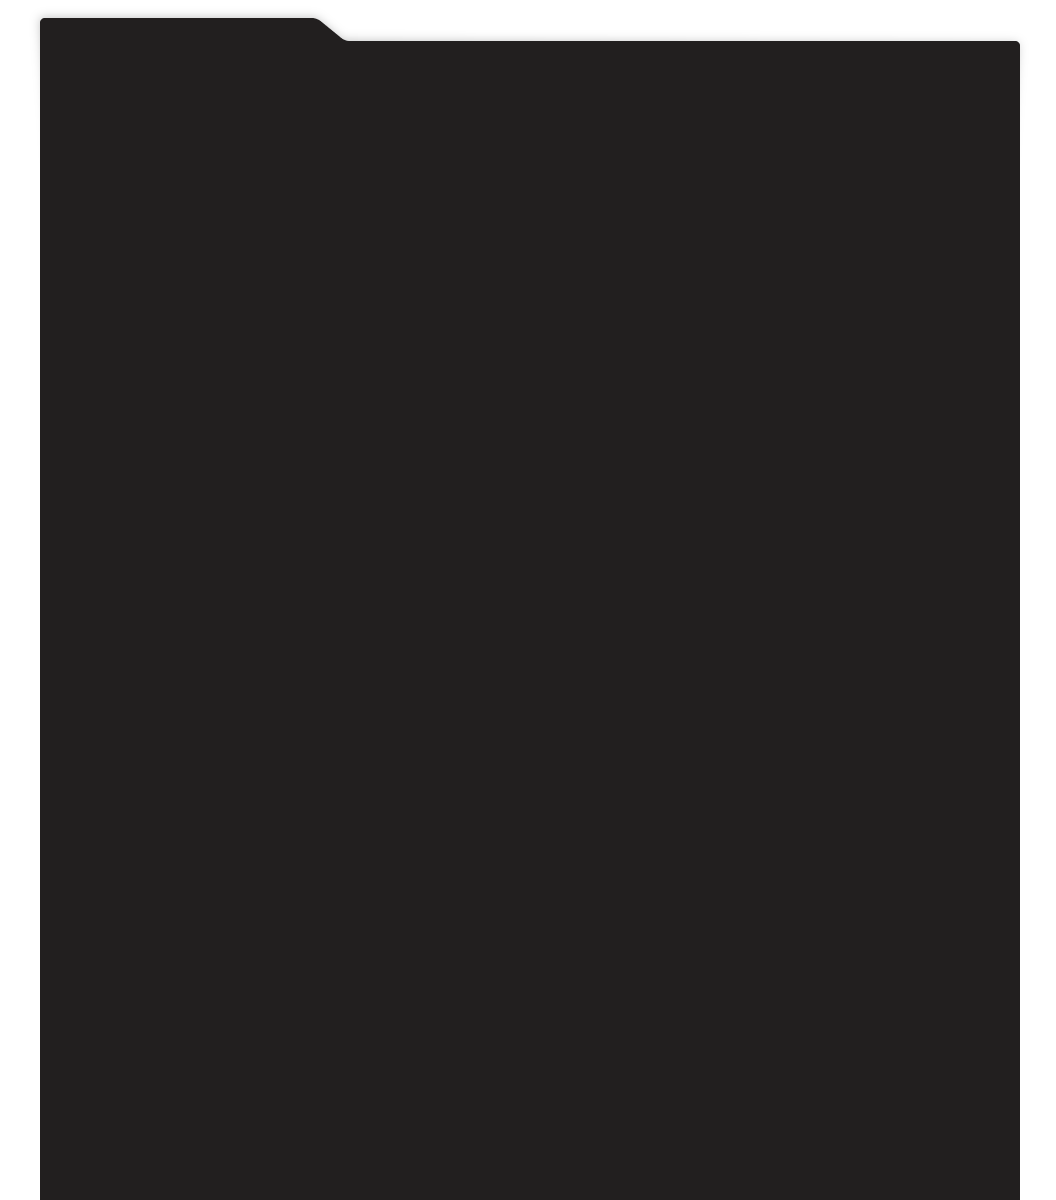
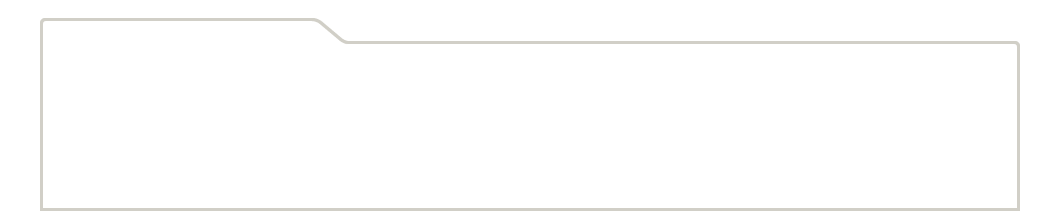
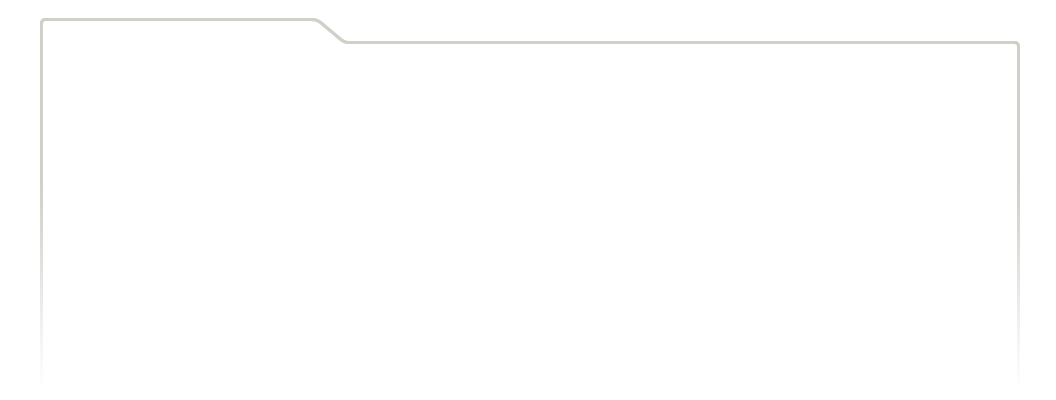
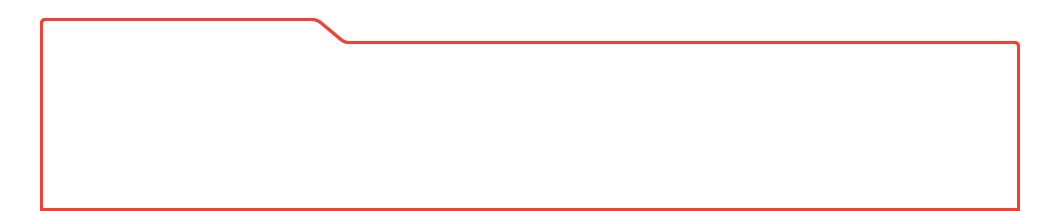
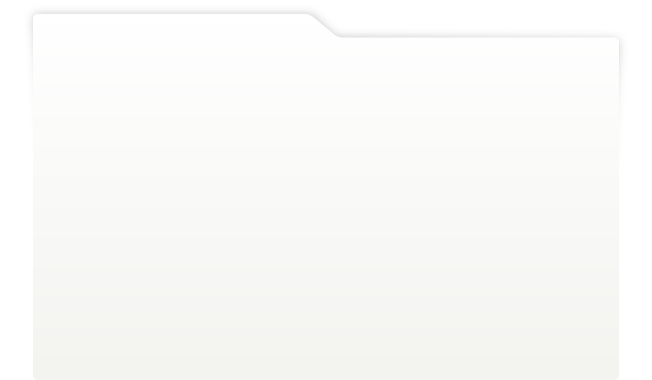
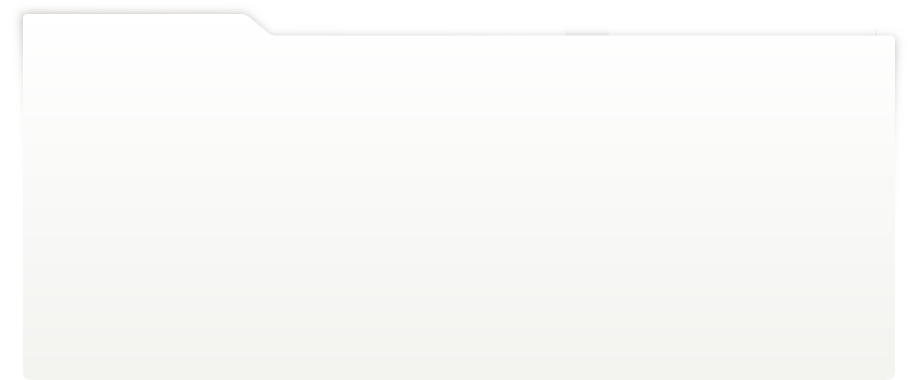
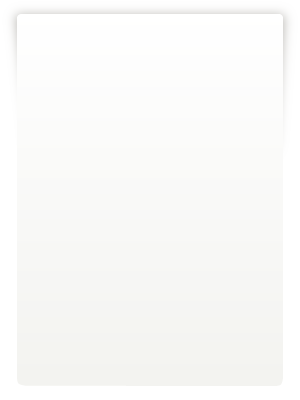
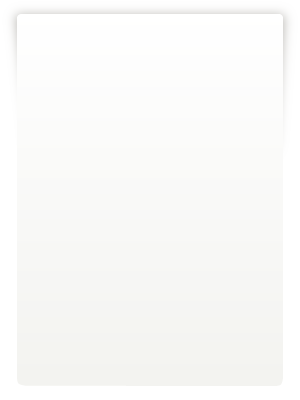
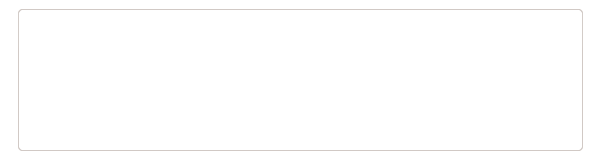
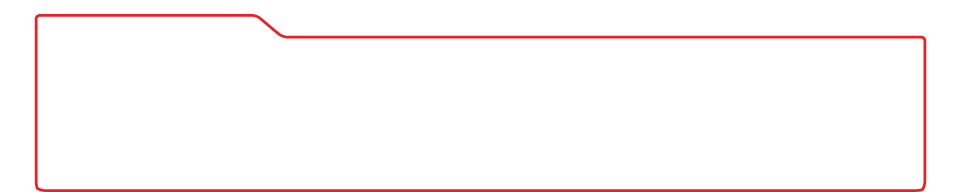
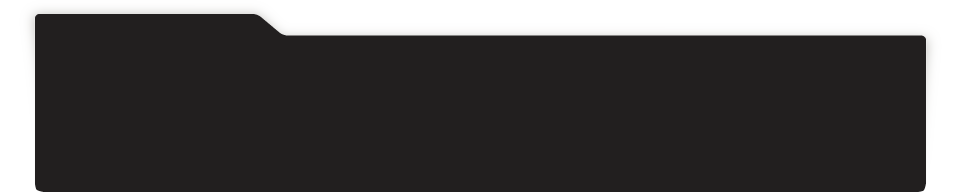
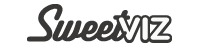
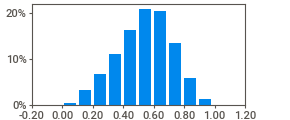
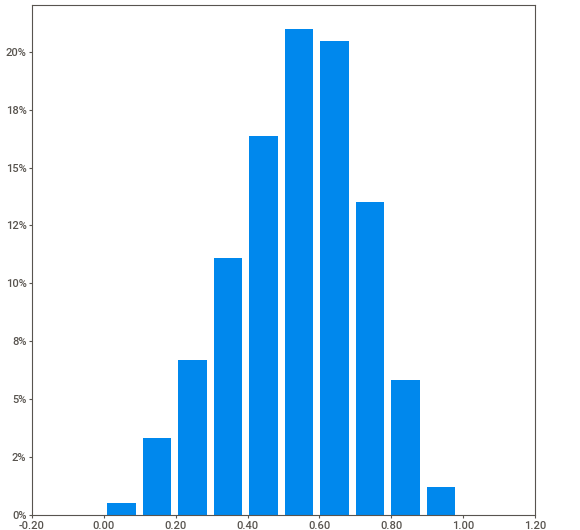
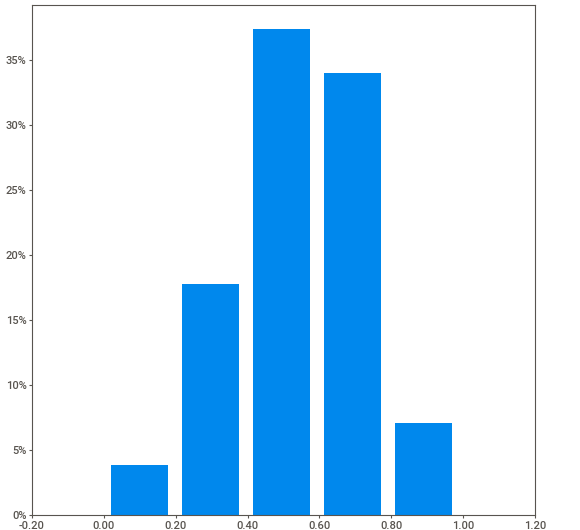
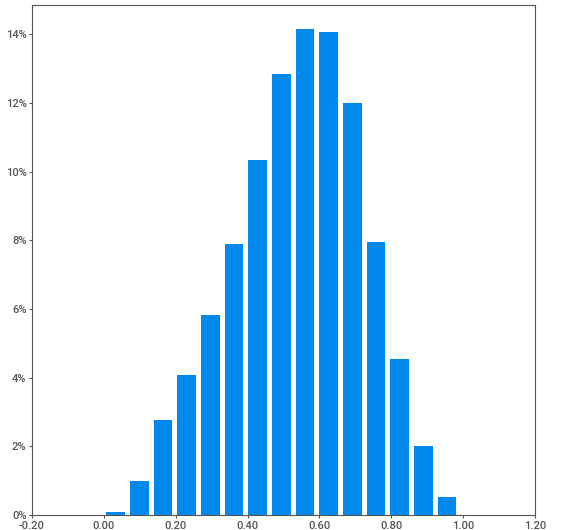
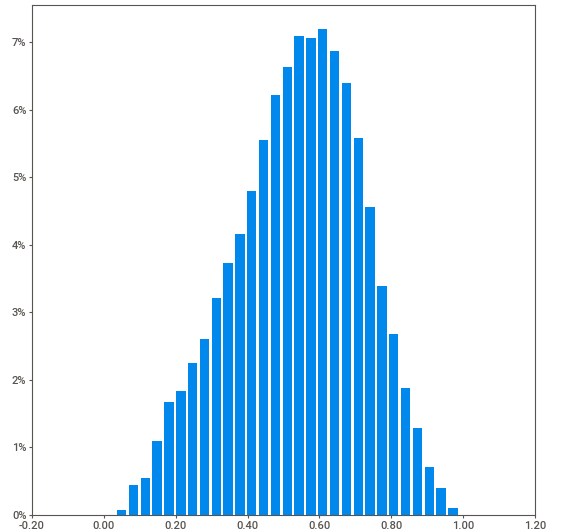
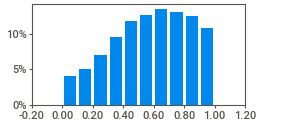
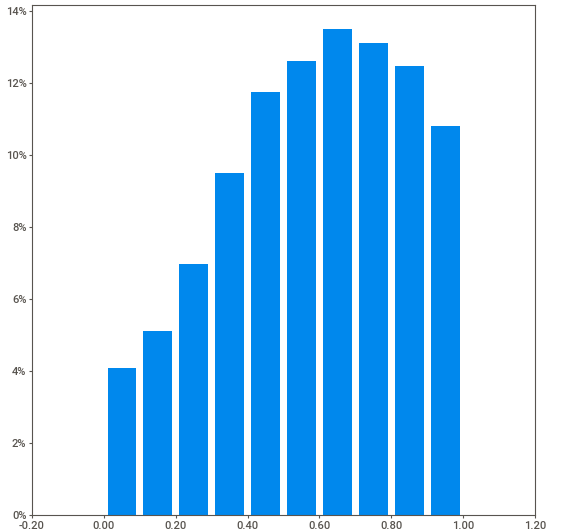
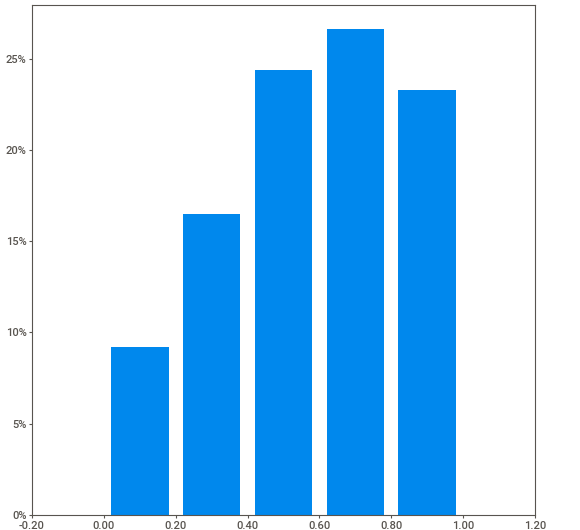
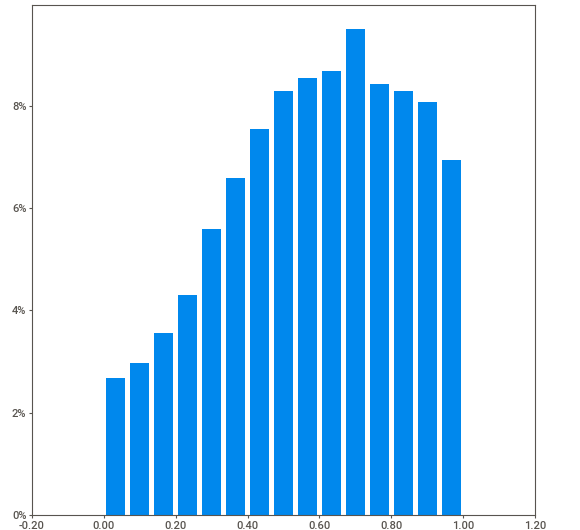
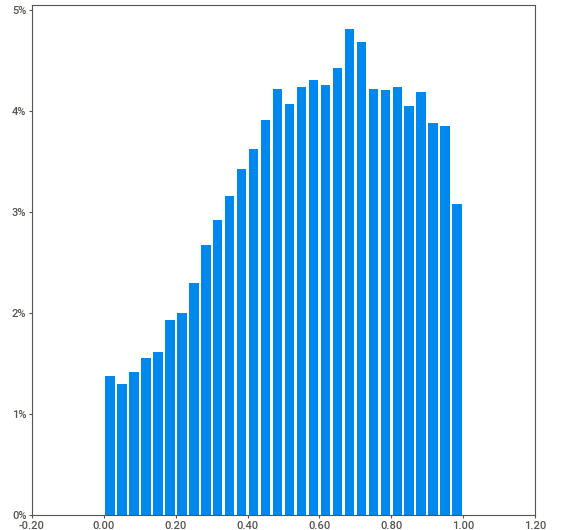
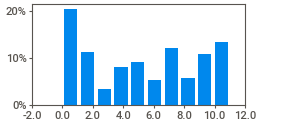
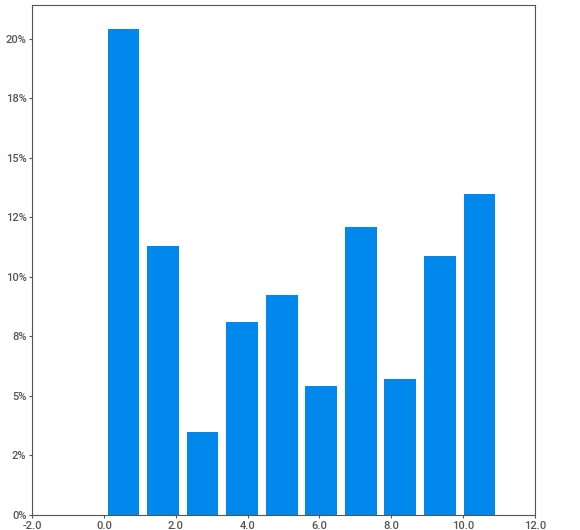
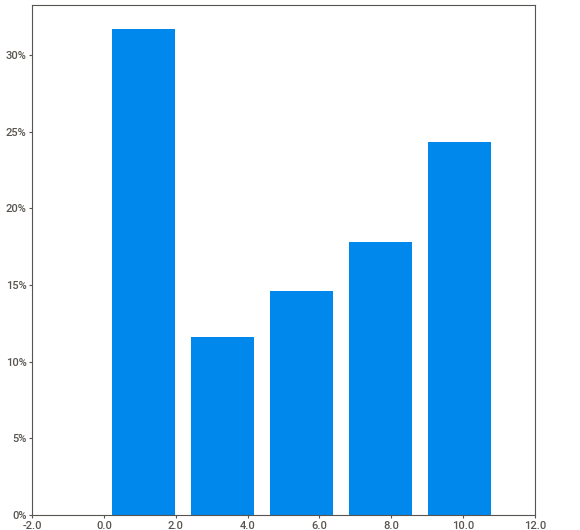
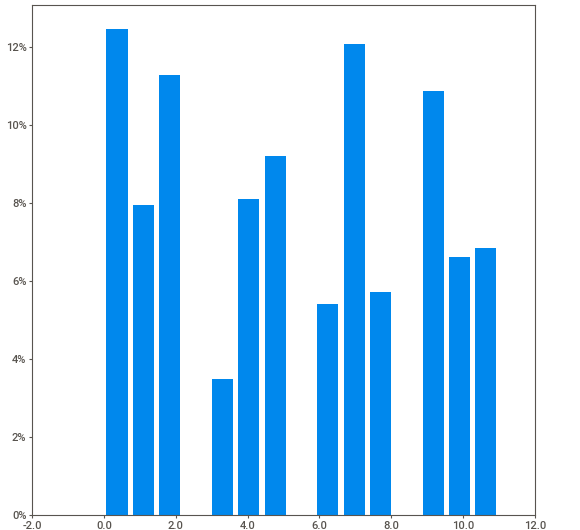
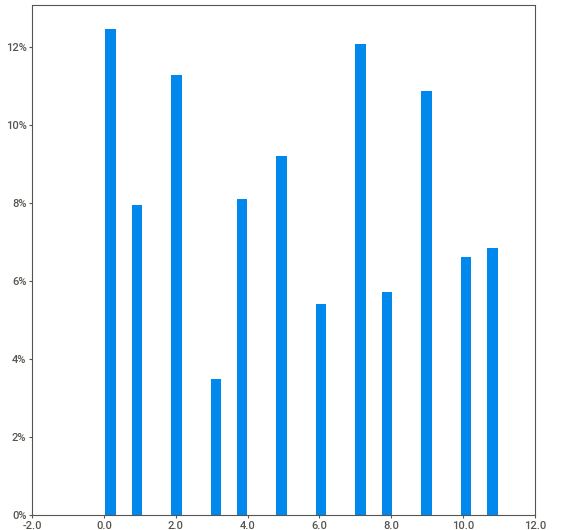
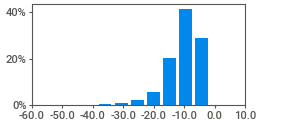
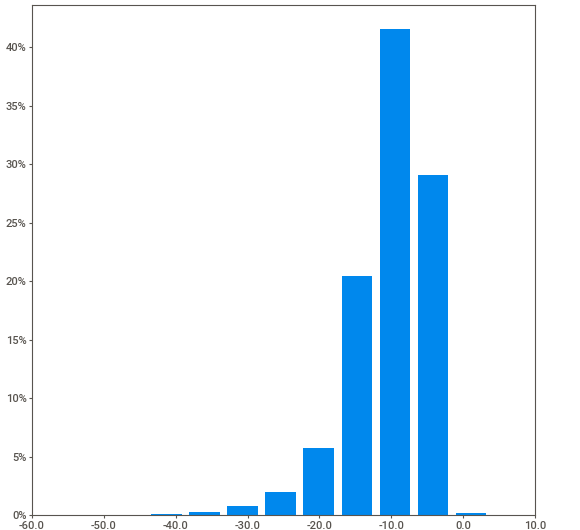
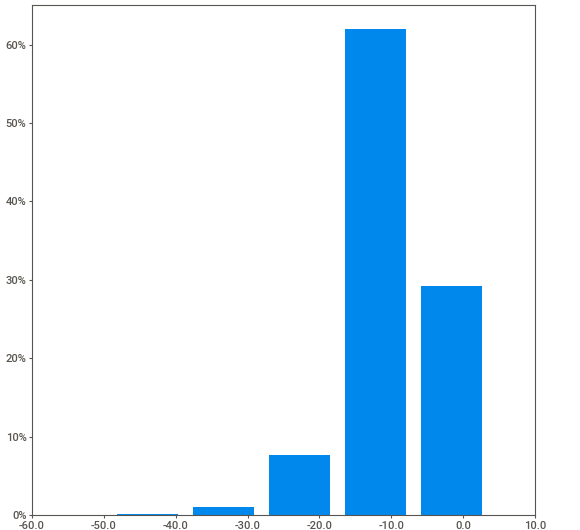
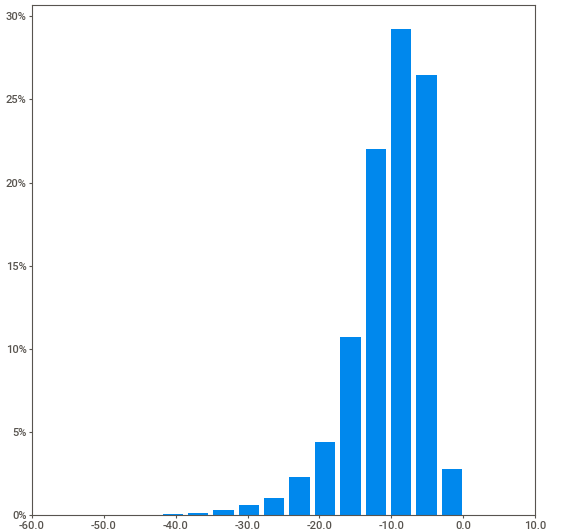
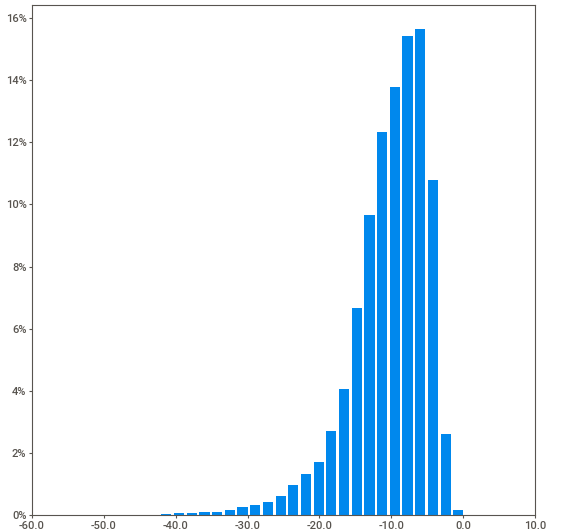
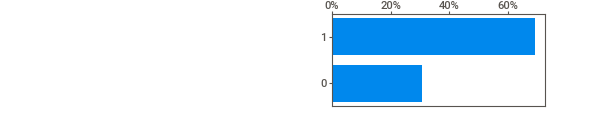
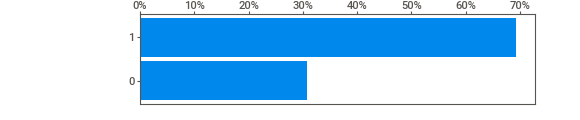
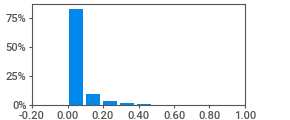
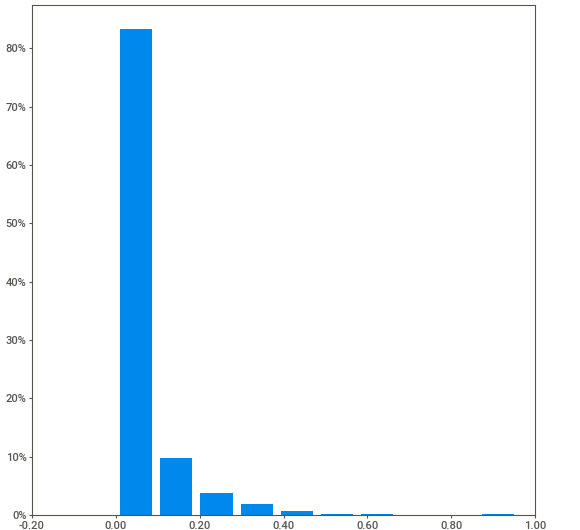
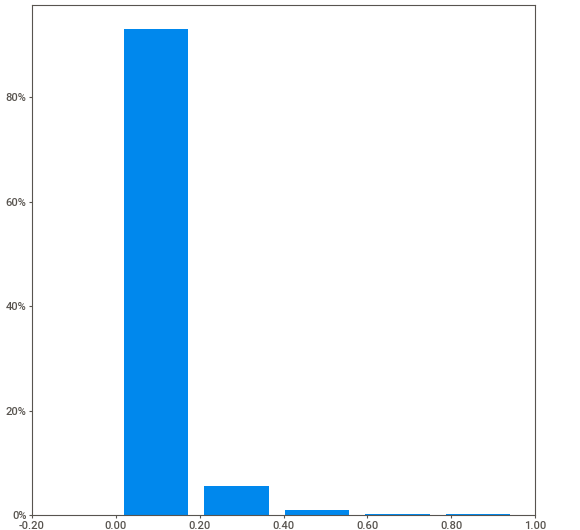
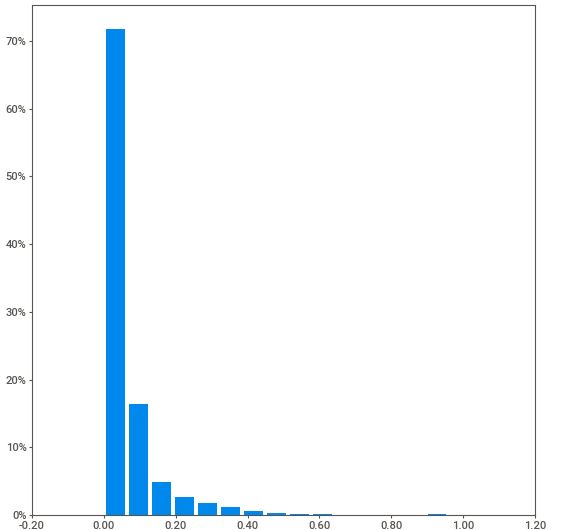
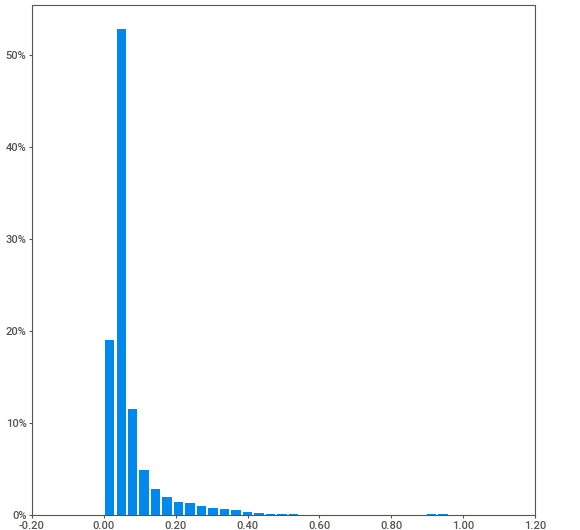
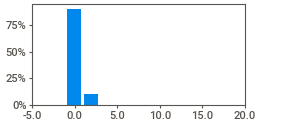
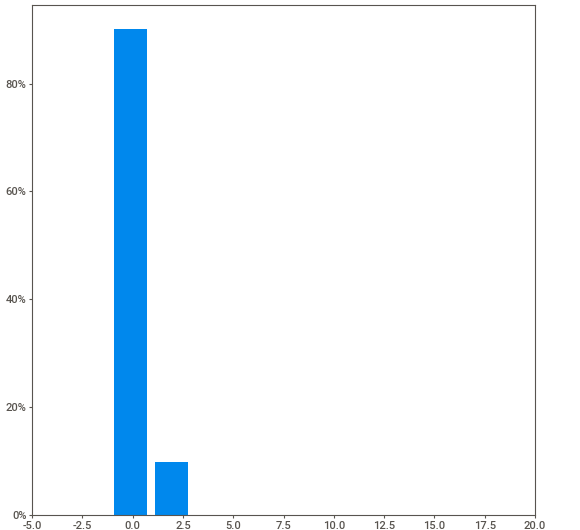
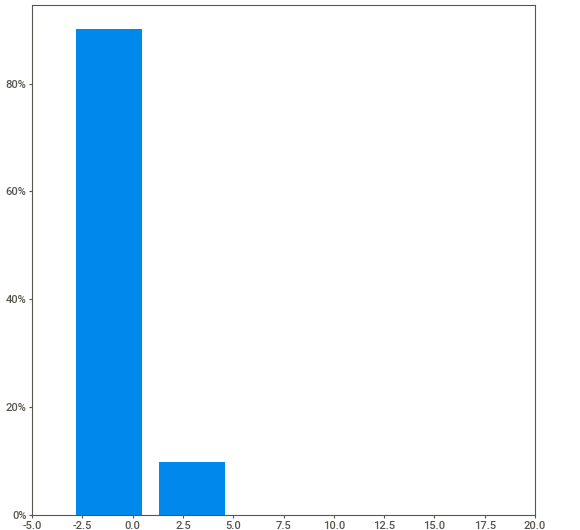
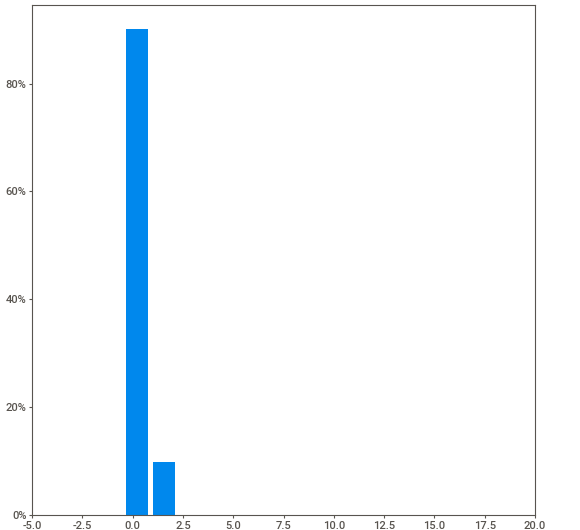
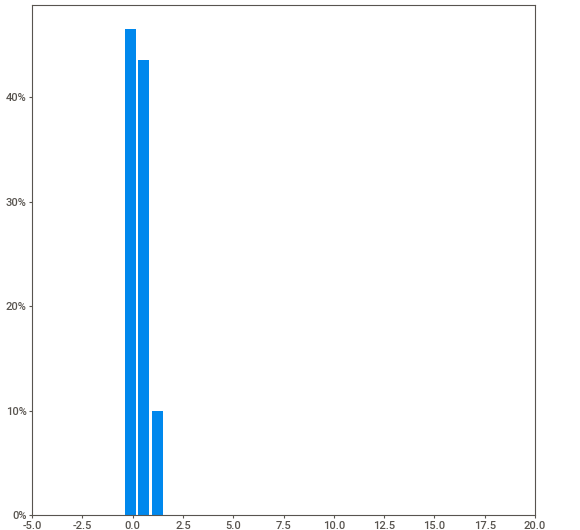
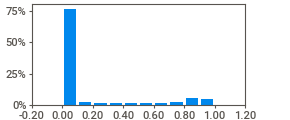
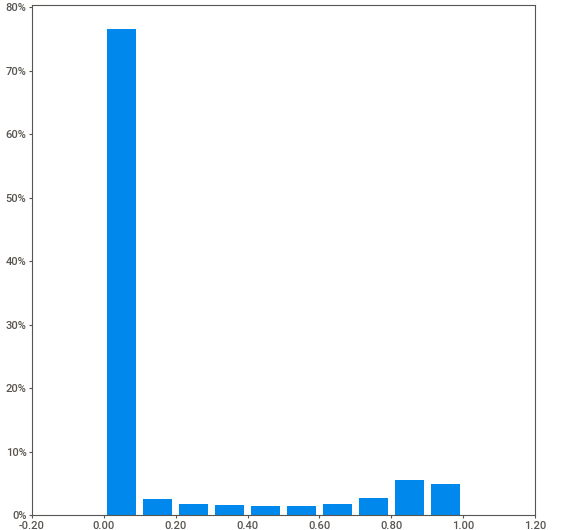
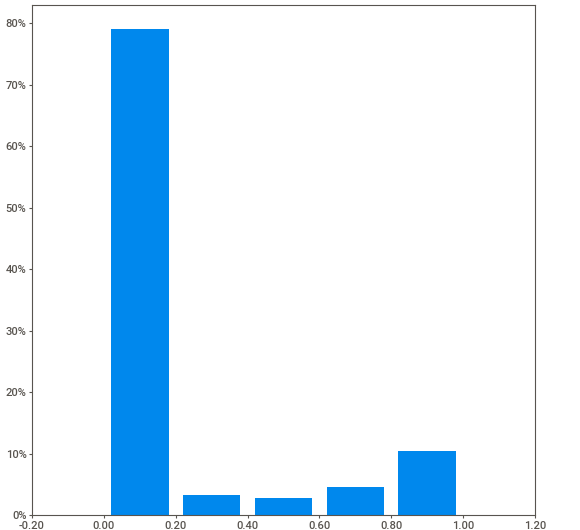
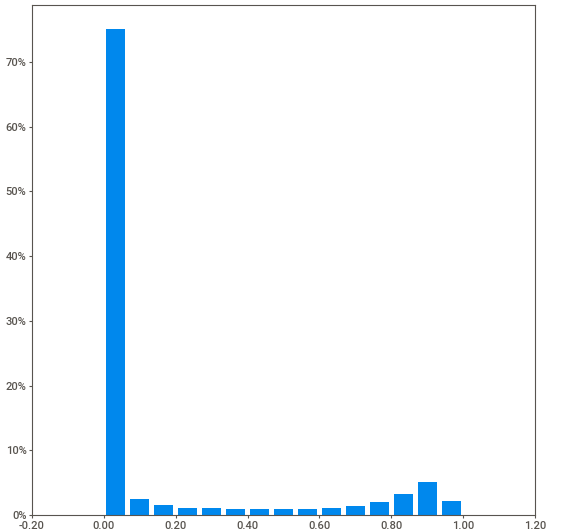
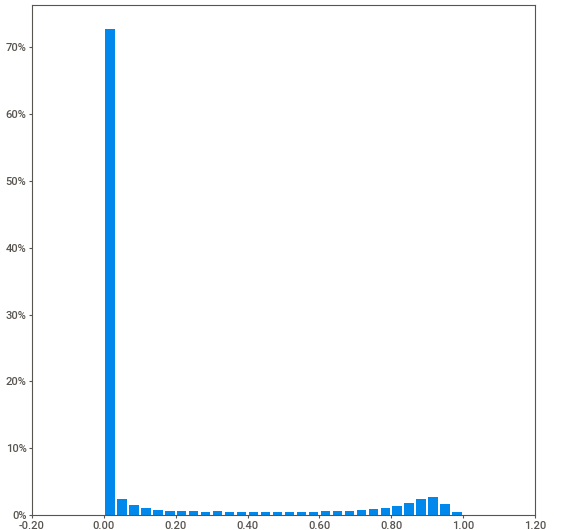
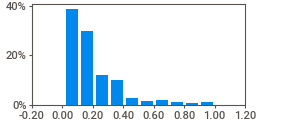
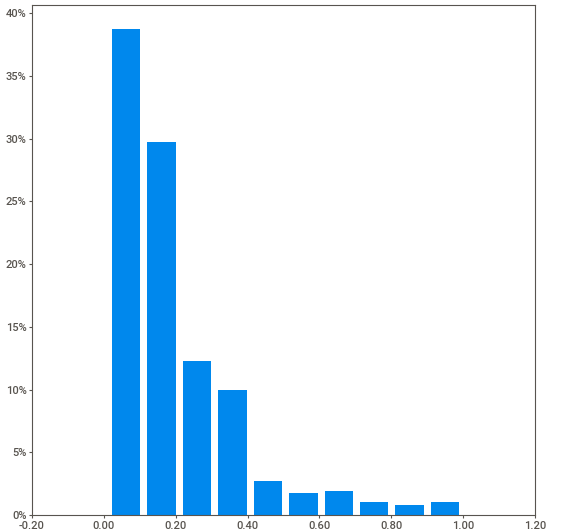
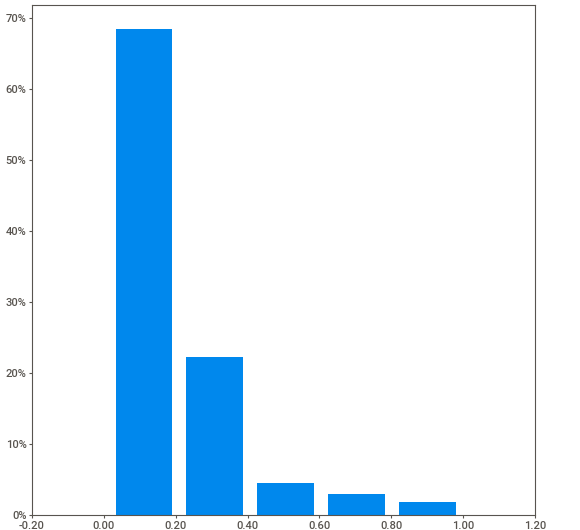
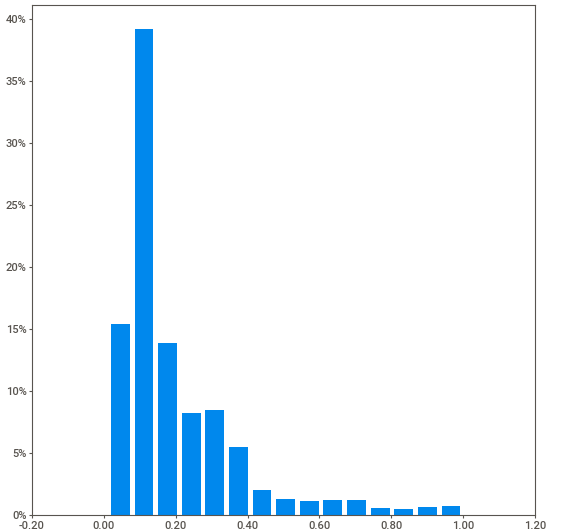
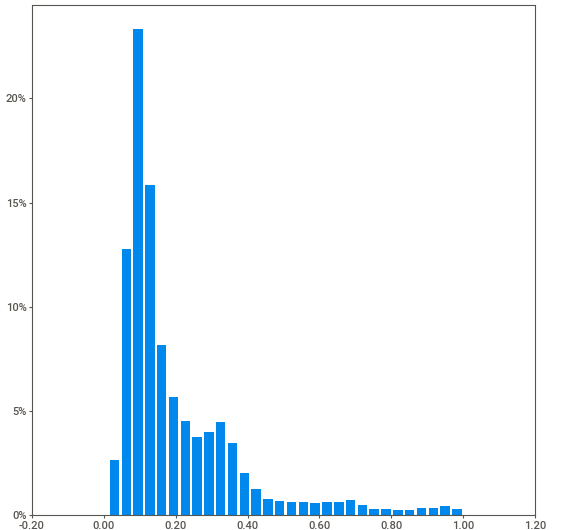
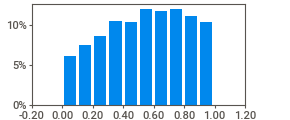
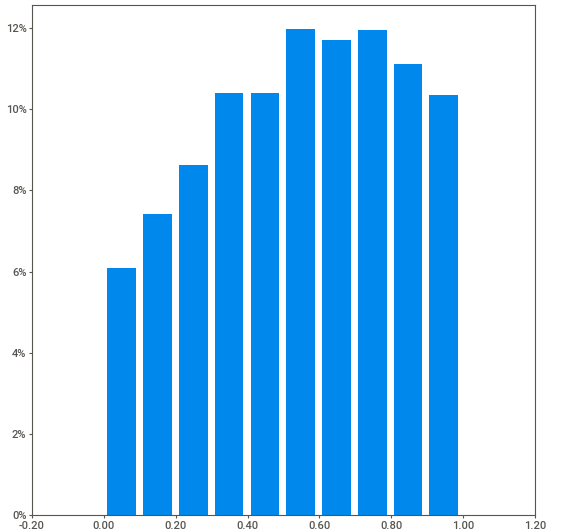
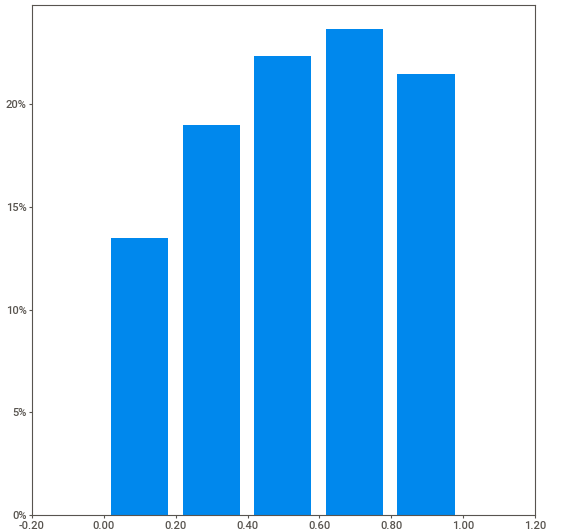
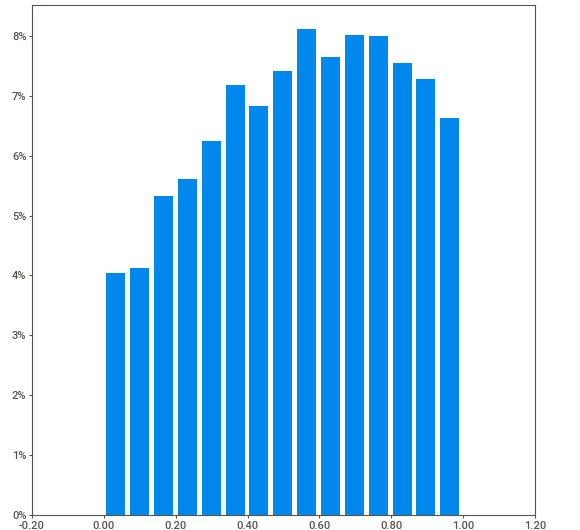
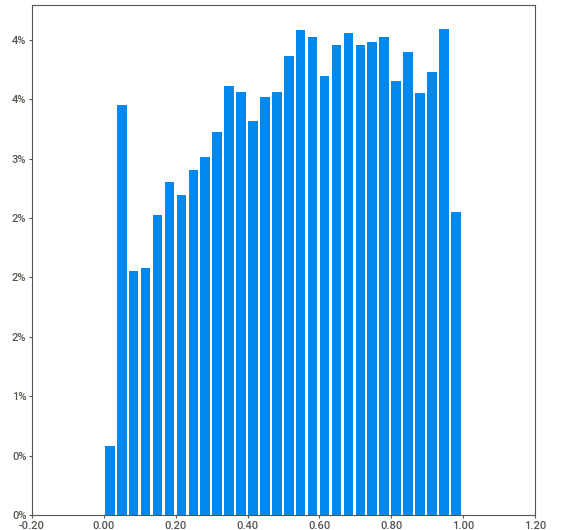
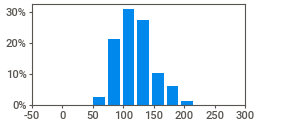
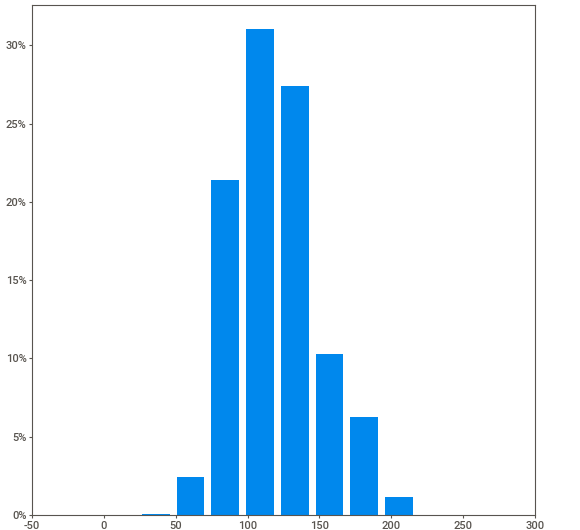
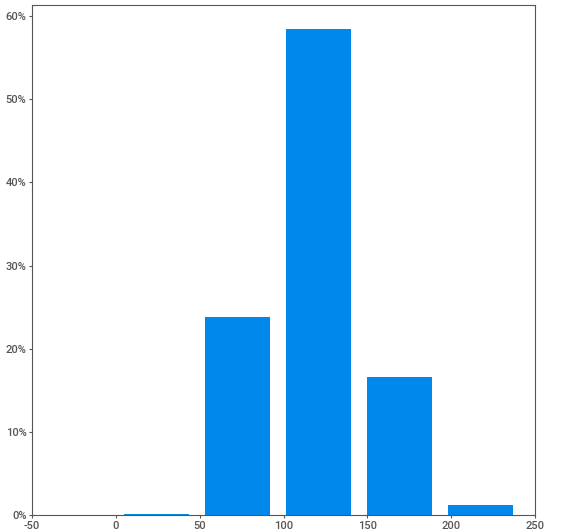
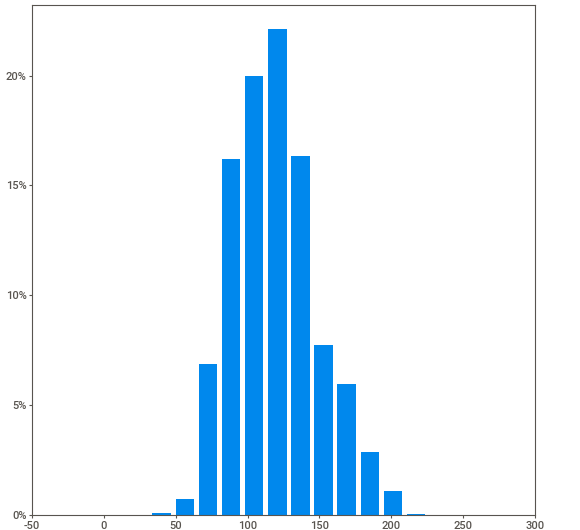
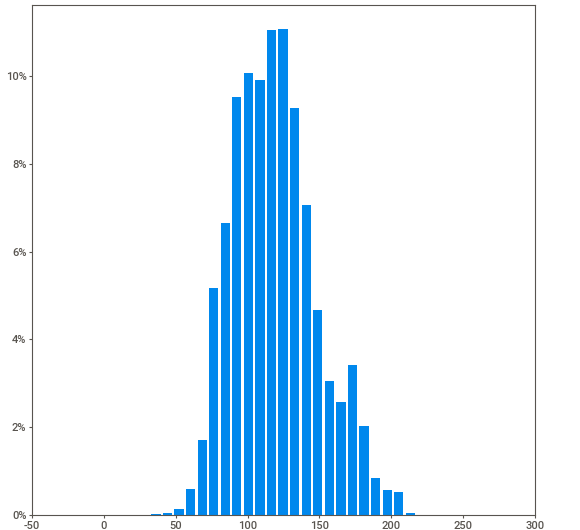
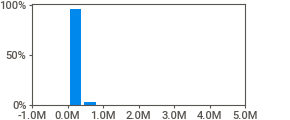
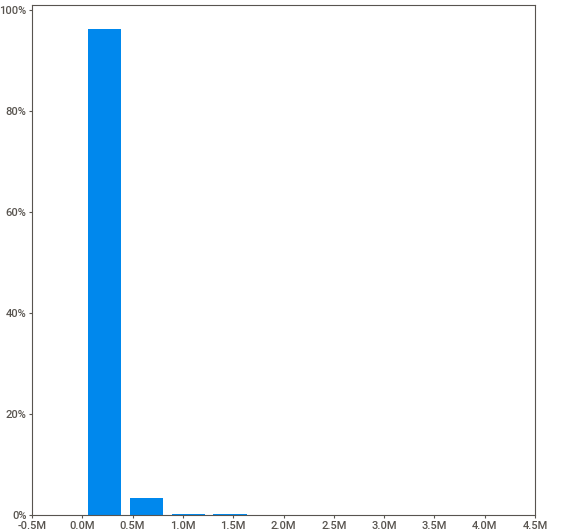
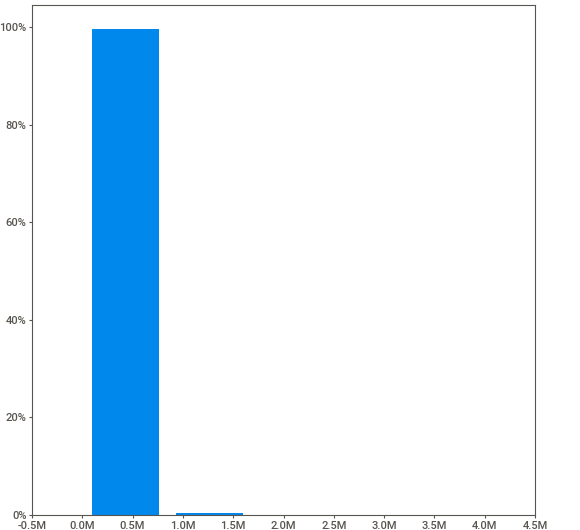
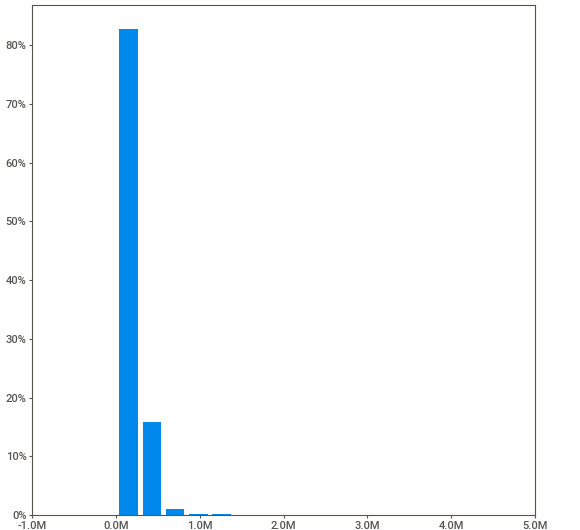
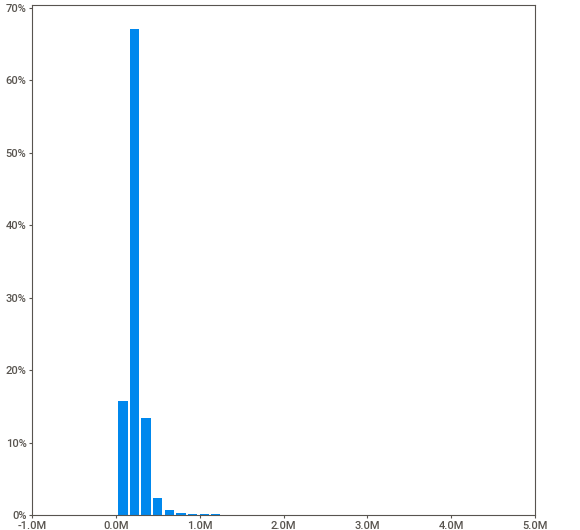
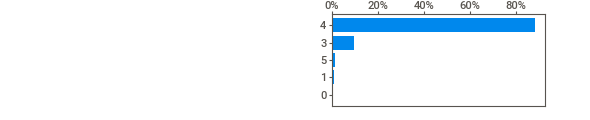
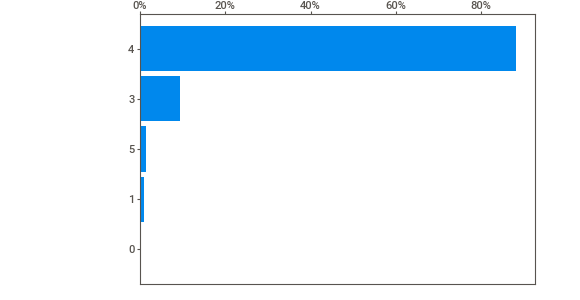
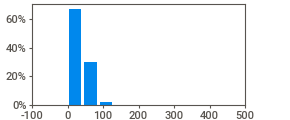
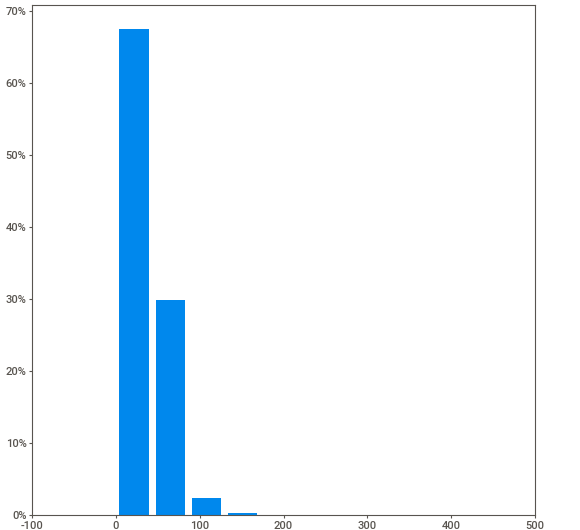
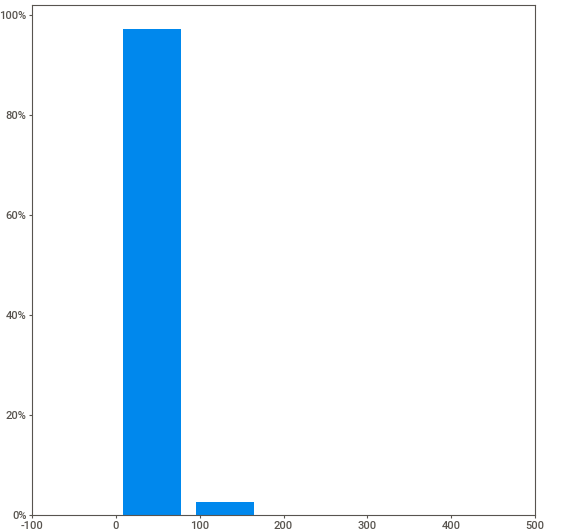
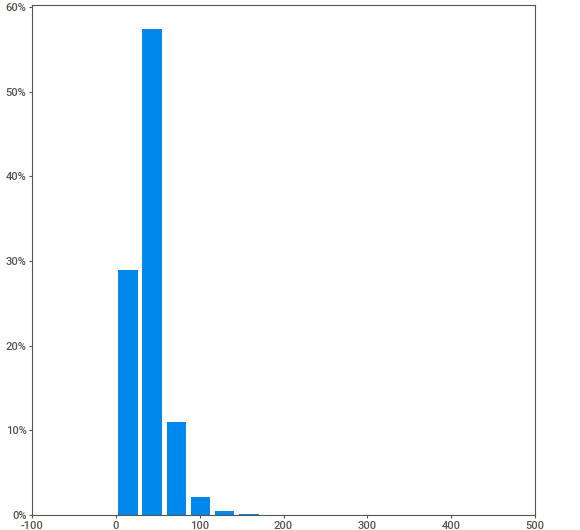
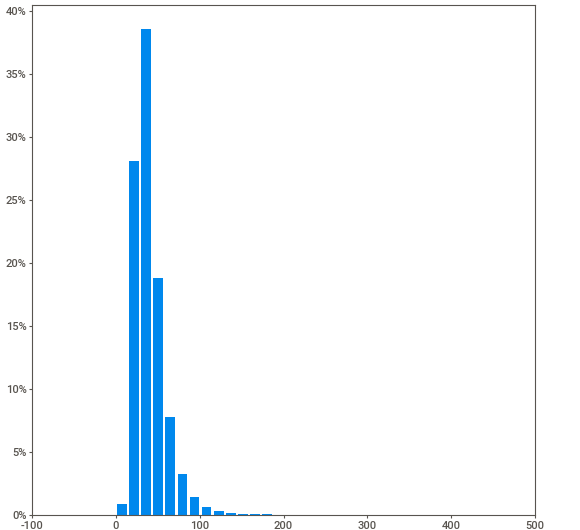
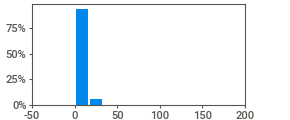
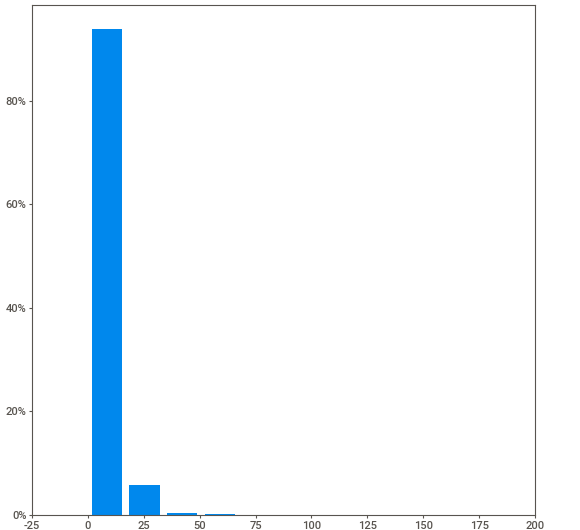
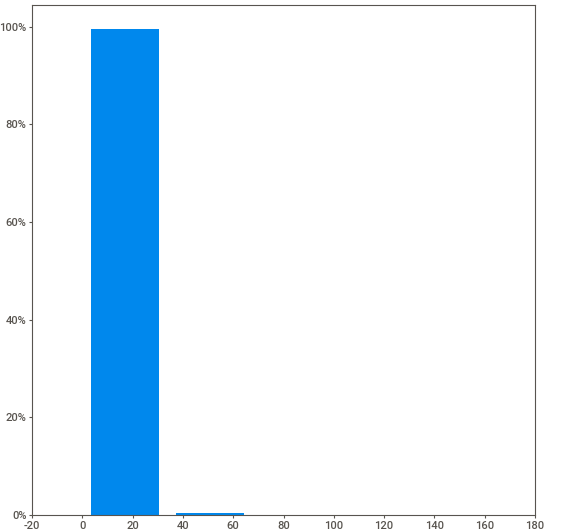
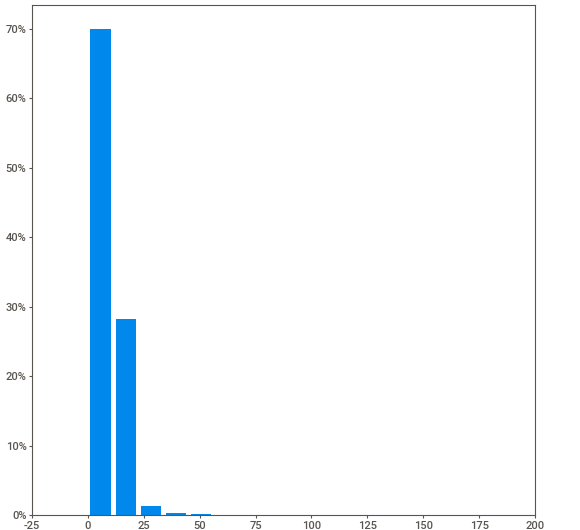
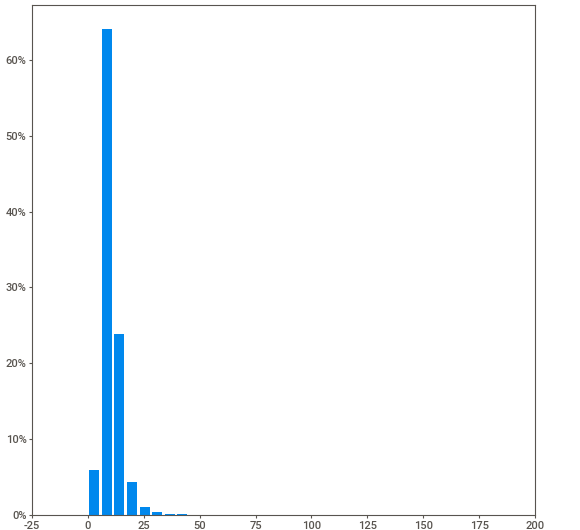
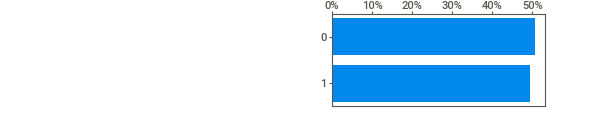
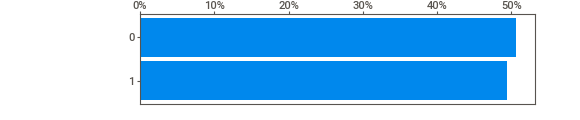
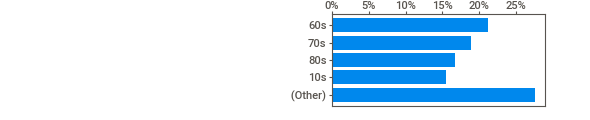
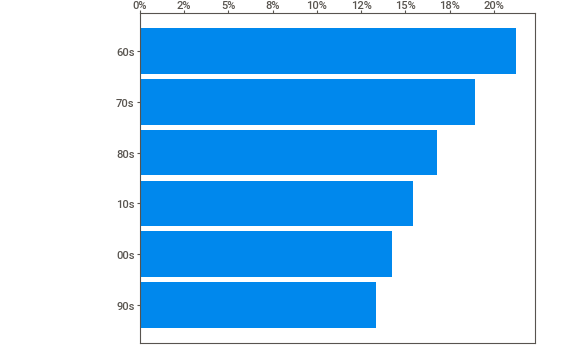
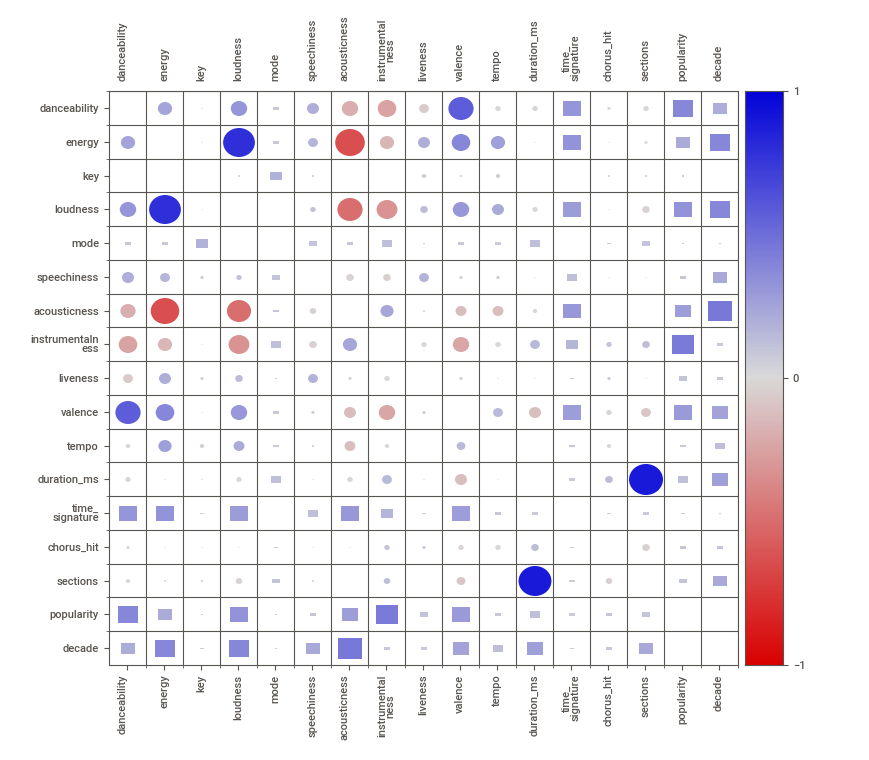
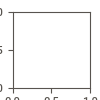

In [25]:
spotify_report.show_notebook()

Histogramy części z kolumn wskazują na to, iż dane te nie posiadają rozkładu normalnego. Warto jednak pamiętać, że prawdziwe dane często nie odznaczają się właśnie rozkładem normlanym, w związku z czym, jeżeli wartości kolumn mieszczą się w zakresach w których powinny się mieścić nie ma powodów do zmieniania lub usuwania tych wartości.

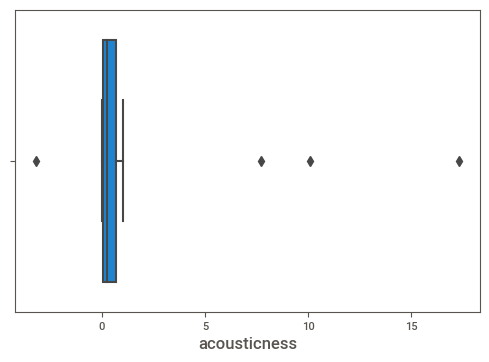

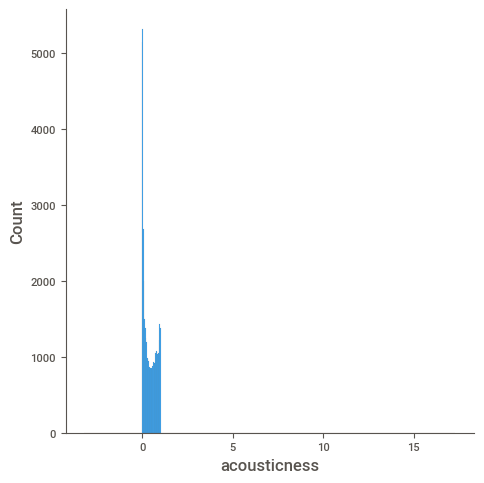

In [26]:
plots_hist_box('acousticness')

Wykres pudełkowy danych w kolumnie accousticness wskazuje na co najmniej 4 punkty znajdujące się zarówno poza zakresem [0-1] jak i zasięgiem wąsów wykresu. Aby pozbyć się tych danych skorzystamy z funkcji whiskers_length, która wyznacza długość wąsów wykresu za pomocą metody IQR, a następnie z funkcji dropping_outliers. 
Po każdym uruchomieniu funkcji odpowiedzialnej za usunięcie danych odstającyh, warto upewnić się, poprzez ponowne uruchomienie wykresów danej zmiennej, że wszytkie dane znajdują się w wyznaczonym zakresie.

In [27]:
lower_limit, upper_limit = whiskers_length('acousticness')
dropping_outliers('acousticness', lower_limit,upper_limit)

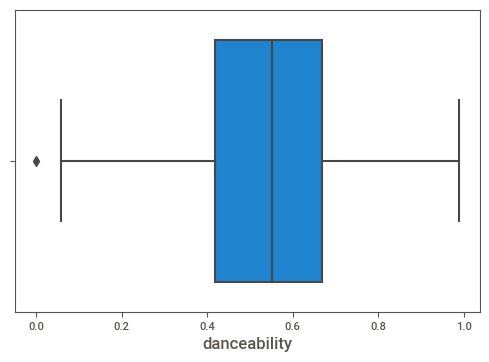

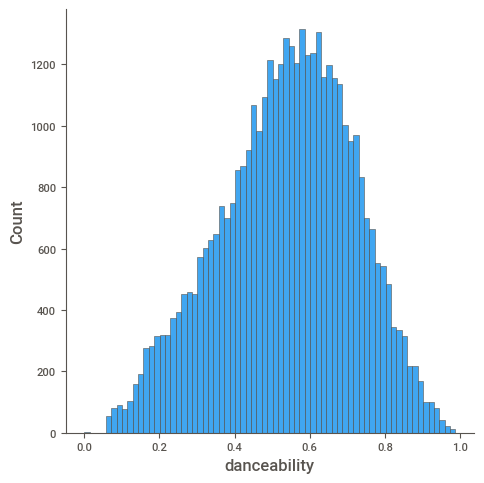

In [28]:
plots_hist_box('danceability')

In [29]:
lower_limit, upper_limit = whiskers_length('danceability')
danceability_oultiers = spotify_data[(spotify_data['danceability']>upper_limit)|(spotify_data['danceability']<lower_limit)]
danceability_oultiers

track      artist                                   uri  \
idx                                                                   
6857  Trust In Me  Etta James  spotify:track:5Zu9mG353GB3p26t7M5AmR   

      danceability  energy   key  loudness  mode  speechiness  acousticness  \
idx                                                                           
6857           0.0   0.377  10.0    -6.777     0          0.0         0.776   

      instrumentalness  liveness  valence  tempo  duration_ms  time_signature  \
idx                                                                             
6857               0.0      0.39      0.0    0.0     178467.0               0   

      chorus_hit  sections  popularity decade  
idx                                            
6857    26.02934         7           1    60s

Kolumna 'danceability' zawiera jeden wiersz, którego wartość wyraźnie odstaje od reszty danych. Jego wartość wynosi 0, co oznacza, że nadal mieci się w limicie [0-1],a więc nie ma potrzeby pozbywania się tego punktu. 

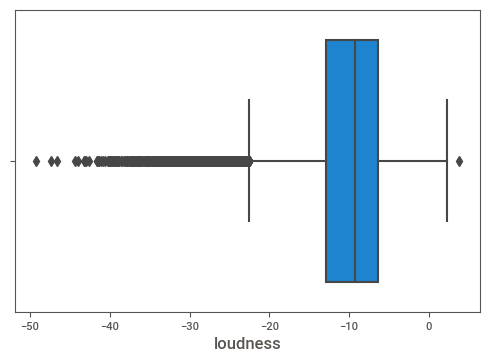

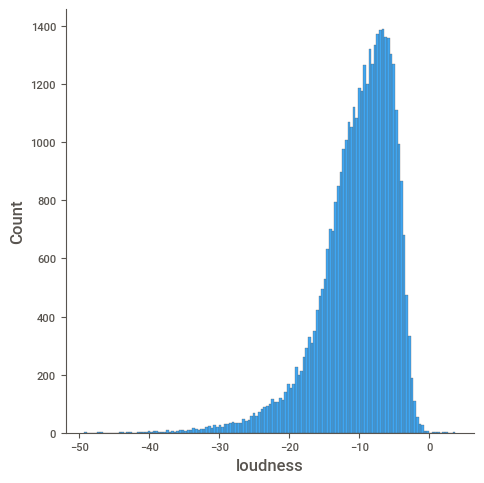

In [30]:
plots_hist_box('loudness')

Wykres pudełkowy kolumny loudness zawiera znacznie większą ilośc danych odstających, niż poprzednie kolumny. Z wcześniej wykonanego podsumowania, wiadomo, iż w kolumnie zawarta jest co najmniej jedna wartość błędna, wykraczająca poza zakres [-60, 0]. 

In [31]:
loudness_above_0 = spotify_data[spotify_data['loudness']>0]
loudness_above_0

track         artist  \
idx                                                                       
8680                   Search and Destroy - Iggy Pop Mix    The Stooges   
11117                              Like A Sunday Morning  Lana Cantrell   
12142        Gimme Danger - Alternate 'Violent' Iggy Mix    The Stooges   
14709                          Death Trip - Iggy Pop Mix    The Stooges   
16289  Your Pretty Face Is Going to Hell - Alternate ...    The Stooges   
29473                                      Dance of Lust      Freakshow   

                                        uri  danceability  energy  key  \
idx                                                                      
8680   spotify:track:00sydAz6PeOxYzwG1dRIPi         0.235   0.977  6.0   
11117  spotify:track:3jjBnB7v3HpQ0VD4A3QE5U         0.363   0.884  3.0   
12142  spotify:track:77bHrxVX3E2SWopfaoWrTw         0.378   0.951  3.0   
14709  spotify:track:7bqn4e3nGorbHDgP3yL9G7         0.228   0.998  2.0   
16289  spotify:track:0Aveu2KsriohUafrrerz1F         0.186   0.997  9.0   
29473  spotify:track:1ZlCP70vdRmQI4qMvPpXIS         0.452   0.983  2.0   

       loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
idx                                                                            
8680      0.878     1       0.1070      0.003530          0.006040    0.1720   
11117     2.291     1       0.0375      0.104000          0.000000    0.1500   
12142     0.450     0       0.0566      0.003290          0.419000    0.1350   
14709     1.963     1       0.1530      0.006160          0.221000    0.0746   
16289     3.744     1       0.1540      0.000467          0.020200    0.0644   
29473     1.137     0       0.0694      0.001360          0.000192    0.1330   

       valence    tempo  duration_ms  time_signature  chorus_hit  sections  \
idx                                                                          
8680    0.2410  152.952     208133.0               4    19.04955        11   
11117   0.4760   81.470     189989.0               4    29.23695         9   
12142   0.2490  132.060     213093.0               4    43.98334        10   
14709   0.0768  155.804     367133.0               4    26.65973        17   
16289   0.1070  157.047     294467.0               4    37.49109        13   
29473   0.5560  148.829     216880.0               4    52.53548        13   

       popularity decade  
idx                       
8680            0    70s  
11117           1    70s  
12142           0    70s  
14709           0    70s  
16289           0    70s  
29473           0    00s

Istnieje 6 obserwacji wartości loudness, które posiadają wartości większe od 0. Istnieje prawdopodobieństwo, iż obserwacje te są wynikiem zagubienia znaku - przed liczbą. Aby uniknąć usuwania całych wierszy wartości te zostaną zamienione na wartości ujemne.  

In [32]:
for idx in loudness_above_0.index:
    loudness_val = -abs(loudness_above_0.loc[idx, 'loudness'])
    spotify_data.loc[spotify_data.index == idx, 'loudness'] = loudness_val

### Redukcja danych

Wybrany zbiór posiada stosunkowo dużą liczbę kolumn, co może niekorzystnie wpłynąć na wyniki modelu, znacznie utrudnić mu podejmowanie decyzji lub wielokrotnie wydłużyć czas jego uczenia. W tym celu stosowana jest redukcja danych. Jedną z jej metod jest sprawdzenie korelacji pomiędzy poszczególnymi kolumnami. Jeżeli jest ona wysoka, wówczas pozbywamy się jednej ze skorelowanych kolumn. 

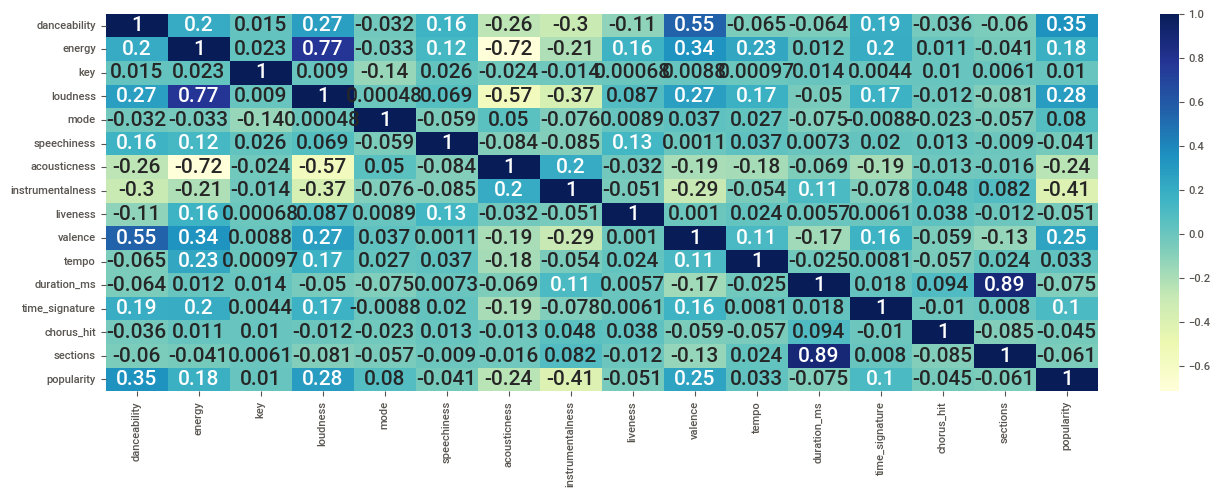

In [33]:
plt.figure(figsize = (16,5))  
heatmap_corr = sns.heatmap(spotify_data.corr(),cmap="YlGnBu",annot=True, annot_kws={'size': 15})

Wnioskując z powyższej heatmapy, koumny duration_ms oraz loudness i energy  są wysoce skorelowane. Ich współczynniki korelacji wynoszą odpowiednio 0.89 oraz 0.77. W związku z powyższym, należy usunąć jedną z kolumn z każdej pary.Aby zdecydować która z kolumn zostanie usunięta, sprawdzimy kolrelacje z wartością, która będzie przewidywana, to jest popularity. Kolumna z niższą wartością korelacji zostanie usunięta ze zbioru.

In [34]:
print(spotify_data[['duration_ms','popularity']].corr())
print(spotify_data[['sections','popularity']].corr())

             duration_ms  popularity
duration_ms     1.000000   -0.075393
popularity     -0.075393    1.000000
            sections  popularity
sections    1.000000   -0.061332
popularity -0.061332    1.000000


In [35]:
print(spotify_data[['loudness','popularity']].corr())
print(spotify_data[['energy','popularity']].corr())

            loudness  popularity
loudness    1.000000    0.284426
popularity  0.284426    1.000000
              energy  popularity
energy      1.000000    0.175669
popularity  0.175669    1.000000


In [36]:
spotify_data.drop(axis=1, columns='sections', inplace=True)
spotify_data.drop(axis=1, columns='energy', inplace=True)

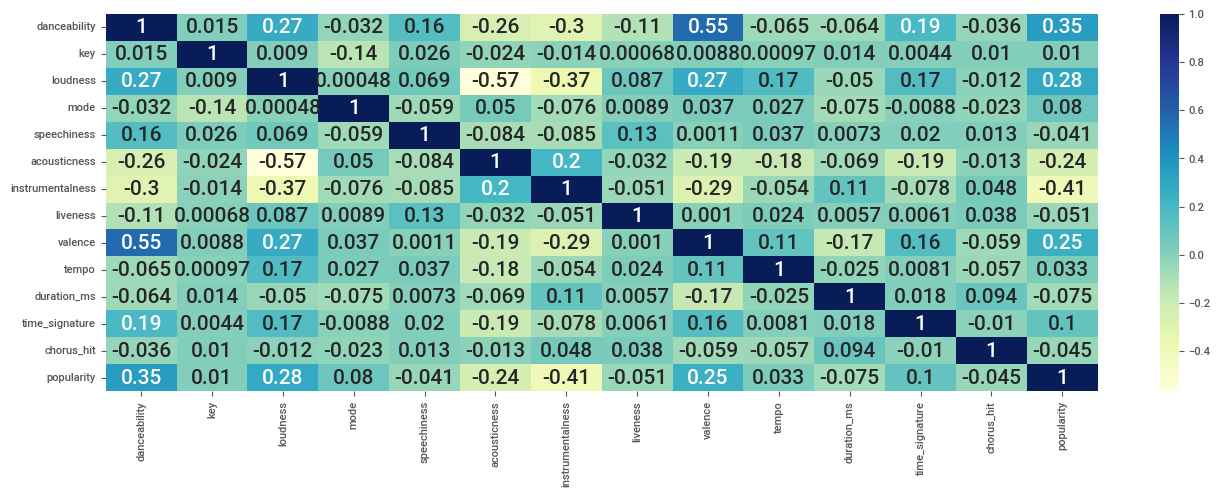

In [37]:
plt.figure(figsize = (16,5))
heatmap_corr = sns.heatmap(spotify_data.corr(),cmap="YlGnBu",annot=True, annot_kws={'size': 15})

Na poprzednim wykresie można było zauważyć, iż kolumna energy posiadała również wysoką ujemną korelację z kolumną accousticness, jednak ponieważ kolumna energy została usunięta ze zbioru, ta korelacja również zniknęła.

### Zamiana danych kategorycznych na numeryczne

Jak wcześniej już zostało zaznaczone, kolumna decade jest kolumną, która zawiera dane kategoryczne, czyli takie, których nie możemy wprowadzić do wielu modeli uczenia maszynowego. Aby było to możliwe, należy zamienić te dane, na dane numeryczne. Zrobione to zosatnie za pomocą label encoding. W pierwszej kolejności sprawdzimy ilość unikalnych wartości w tej kolumnie, aby podjąć decyzję, jaka metoda zostanie użyta.

In [38]:
spotify_data['decade'].nunique()

6

Ilość kategorii w kolumnie decade wynosi 6, co jest akceptowalną liczbą do skorzystania z metody one hot encoding. Warto jednak zwrócić uwagę, iż liczba pozostałych kolumn jest dość wysoka, a po dodaniu kolejnych 6, sprawi że wymiary zbioru będą zbyt duże. Z tego względu zastosowana zostanie metoda label encoding.

In [39]:
label_encoder = preprocessing.LabelEncoder()
spotify_data['decade_num'] = 0
spotify_data['decade_num']= label_encoder.fit_transform(spotify_data['decade'])
spotify_data

track            artist  \
idx                                              
0      Jealous Kind Of Fella     Garland Green   
1              Initials B.B.  Serge Gainsbourg   
2               Melody Twist       Lord Melody   
3              Mi Bomba Sonó        Celia Cruz   
4                Uravu Solla       P. Susheela   
...                      ...               ...   
41094          Lotus Flowers             Yolta   
41095      Calling My Spirit       Kodak Black   
41096          Teenage Dream        Katy Perry   
41097         Stormy Weather    Oscar Peterson   
41098                   Dust       Hans Zimmer   

                                        uri  danceability   key  loudness  \
idx                                                                         
0      spotify:track:1dtKN6wwlolkM8XZy2y9C1         0.417   3.0    -7.727   
1      spotify:track:5hjsmSnUefdUqzsDogisiX         0.498   3.0   -12.475   
2      spotify:track:6uk8tI6pwxxdVTNlNOJeJh         0.657   5.0   -13.392   
3      spotify:track:7aNjMJ05FvUXACPWZ7yJmv         0.590   5.0   -12.058   
4      spotify:track:1rQ0clvgkzWr001POOPJWx         0.515  11.0    -3.515   
...                                     ...           ...   ...       ...   
41094  spotify:track:4t1TljQWJ6ZuoSY67zVvBI         0.172   9.0   -14.430   
41095  spotify:track:2MShy1GSSgbmGUxADNIao5         0.910   1.0    -9.954   
41096  spotify:track:55qBw1900pZKfXJ6Q9A2Lc         0.719  10.0    -4.581   
41097  spotify:track:4o9npmYHrOF1rUxxTVH8h4         0.600   7.0   -16.070   
41098  spotify:track:2khIaVUkbMmDHB596lyMG3         0.121   4.0   -23.025   

       mode  speechiness  acousticness  instrumentalness  liveness  valence  \
idx                                                                           
0         1       0.0403        0.4900          0.000000    0.0779   0.8450   
1         1       0.0337        0.0180          0.107000    0.1760   0.7970   
2         1       0.0380        0.8460          0.000004    0.1190   0.9080   
3         0       0.1040        0.7060          0.024600    0.0610   0.9670   
4         0       0.1240        0.8570          0.000872    0.2130   0.9060   
...     ...          ...           ...               ...       ...      ...   
41094     1       0.0342        0.8860          0.966000    0.3140   0.0361   
41095     1       0.0941        0.0996          0.000000    0.2610   0.7400   
41096     1       0.0355        0.0132          0.000003    0.1390   0.6050   
41097     1       0.0561        0.9890          0.868000    0.1490   0.5600   
41098     0       0.0443        0.9640          0.696000    0.1030   0.0297   

         tempo  duration_ms  time_signature  chorus_hit  popularity decade  \
idx                                                                          
0      185.655     173533.0               3    32.94975           1    60s   
1      101.801     213613.0               4    48.82510           0    60s   
2      115.940     223960.0               4    37.22663           0    60s   
3      105.592     157907.0               4    24.75484           0    60s   
4      114.617     245600.0               4    21.79874           0    60s   
...        ...          ...             ...         ...         ...    ...   
41094   72.272     150857.0               4    24.30824           0    10s   
41095  119.985     152000.0               4    32.53856           1    10s   
41096  119.999     227760.0               4    20.73371           1    10s   
41097  120.030     213387.0               4    21.65301           0    10s   
41098   95.182     341396.0               4    71.05343           0    10s   

       decade_num  
idx                
0               2  
1               2  
2               2  
3               2  
4               2  
...           ...  
41094           1  
41095           1  
41096           1  
41097           1  
41098           1  

[40549 rows x 19 columns]

In [40]:
spotify_data['decade_num'].nunique()

6

# Analiza danych

W pierwszwej kolejności analizie został podany rozkład ilości piosenek w podziale na dekady.

In [41]:
decade = spotify_data['decade']

In [42]:
decade.value_counts()

60s    8622
70s    7683
80s    6801
10s    6260
00s    5767
90s    5416
Name: decade, dtype: int64

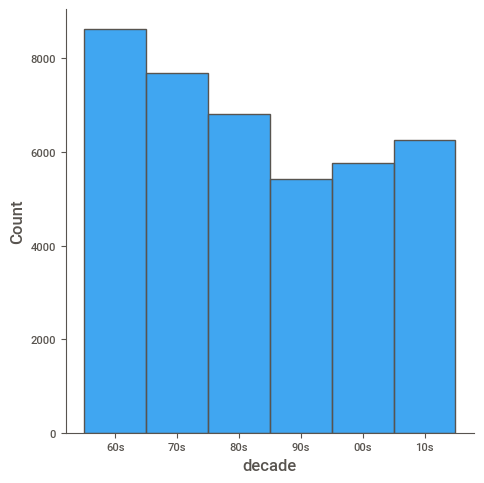

In [43]:
sns.displot(spotify_data, x="decade")

Powyższy wykres jasno wskazuje na to, iż najwięcej piosenek w tym zbiorze danych, pochodzi z lat 60, a najmniej z lat 90. Ilości te zawierają się w przedziale od 5500 do 8700. Następnie przyjrzymy sie jak wygląda rozkład etykiet, czyli kolumny popularity.

In [44]:
spotify_data['popularity'].value_counts()

0    20539
1    20010
Name: popularity, dtype: int64

In [45]:
popular_songs = spotify_data[spotify_data['popularity']==1]
unpopular_songs = spotify_data[spotify_data['popularity']==0]

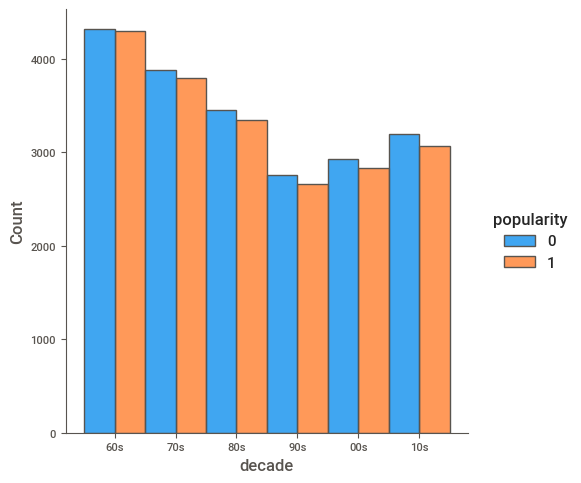

In [46]:
sns.displot(spotify_data, x="decade", hue="popularity", multiple="dodge")

In [47]:
unpopular_songs['decade'].value_counts()

60s    4319
70s    3883
80s    3451
10s    3195
00s    2933
90s    2758
Name: decade, dtype: int64

In [48]:
popular_songs['decade'].value_counts()

60s    4303
70s    3800
80s    3350
10s    3065
00s    2834
90s    2658
Name: decade, dtype: int64

Zastosowanie fukcji value_counts na kolumnie popularity pokazało, iż mamy zbliżoną ilość danych z etykietą 0 oraz 1. Następnie przedstawione zostały winiki rozkładu etykiet danych, z uwzględnieniem dekady, z której każdy z utworów pochodził. Przedstawiony powyżej wykres jasno pokazuje, iż dla każdej z dekad uwzględnionych w zbiorze danych, ilości utwrów z etykietą 0 jest za każdym razem większa, jednak nadal zbliżona do ilości utworów z etykietą 1. Umieszczone poniżej wykresu dokładne dane liczbowe również to potwierdzają. Oznacza to, iż dane są zbilansowane.


# Tworzenie modelu 

Celem modelu stworzonego na podstawie zbioru spotify_data jest przewidzenie czy utwór uzyskał popularność, czy też nie. Przedstawiony problem jest problemem klasyfikacji. Do zbudowania modelu wykorzystanych zostanie pięć algorytmów: K-najbliższych sąsiadów, Maszyna Wektorów Nośnych, Las Losowy oraz Gradient Boost. W pierwszej kolejności modele zostaną stworzone bez korzystania z walidacji krzyżowej, tak aby ustalić który z nich będzie najlepiej dopasowany do danych. 

In [49]:
spotify_data.columns

Index(['track', 'artist', 'uri', 'danceability', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'popularity', 'decade', 'decade_num'],
      dtype='object')

In [50]:
feature_names = ['danceability', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit', 'decade_num']
target = 'popularity'

In [51]:
X = spotify_data[feature_names]
y = spotify_data[target]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 32) 

### K-Najbliższych sąsiadów

In [53]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(f'Metryki: {classification_report(y_test, knn_pred)}')

Metryki:               precision    recall  f1-score   support

           0       0.57      0.53      0.55      6064
           1       0.56      0.61      0.59      6101

    accuracy                           0.57     12165
   macro avg       0.57      0.57      0.57     12165
weighted avg       0.57      0.57      0.57     12165



### Maszyna wektorów nośnych 

In [54]:
svc = SVC()
svc.fit(X_train, y_train)
grid_pred =  svc.predict(X_test)
print(f'Metryki: {classification_report(y_test, grid_pred)}')

Metryki:               precision    recall  f1-score   support

           0       0.68      0.38      0.49      6064
           1       0.57      0.82      0.67      6101

    accuracy                           0.60     12165
   macro avg       0.62      0.60      0.58     12165
weighted avg       0.62      0.60      0.58     12165



### Las losowy

In [55]:
rf = RandomForestClassifier()
rf.fit(X_train.values, y_train.values)
rf_pred =  rf.predict(X_test.values)
print(f'Metryki: {classification_report(y_test, rf_pred)}')

Metryki:               precision    recall  f1-score   support

           0       0.82      0.76      0.79      6064
           1       0.78      0.84      0.80      6101

    accuracy                           0.80     12165
   macro avg       0.80      0.80      0.80     12165
weighted avg       0.80      0.80      0.80     12165



### Gradient Boost

In [56]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
print(f'Metryki: {classification_report(y_test, gb_pred)}')

Metryki:               precision    recall  f1-score   support

           0       0.83      0.73      0.78      6064
           1       0.76      0.85      0.80      6101

    accuracy                           0.79     12165
   macro avg       0.79      0.79      0.79     12165
weighted avg       0.79      0.79      0.79     12165



Spośród badanych modeli zdecydowanie najlepszymi wynikami odznaczają się: Las Losowy oraz Gradient Boost. Ze względu na to, iż minimalnie lepszy okazał się Las Losowy, to on zostanie wykorzystany do dalszej analizy. 

Na wybranym modelu użyta zostanie funkcja Grid Search, która pozwoli na dopasowanie najlepszych hiperparametrów. Pozwoli ona również na przeprowadzenie walidacji krzyżowej.

In [57]:
rf =RandomForestClassifier()
param_grid_rf = {
    'max_depth' : [18, 21, 24],
    'max_features' : [ 'sqrt', 'log2'],
    'n_estimators' : [150, 300, 450],
}
grid_rf = GridSearchCV(estimator=rf, cv = 5, param_grid=param_grid_rf)
grid_rf.fit(X_train.values,y_train.values)
print(f'Najlesze parametry spośród badanych: {grid_rf.best_params_}')

Najlesze parametry spośród badanych: {'max_depth': 24, 'max_features': 'sqrt', 'n_estimators': 450}


In [58]:
rf_pred =  grid_rf.predict(X_test.values)
print(f'Metryki: {classification_report(y_test, rf_pred)}')

Metryki:               precision    recall  f1-score   support

           0       0.83      0.76      0.79      6064
           1       0.78      0.84      0.81      6101

    accuracy                           0.80     12165
   macro avg       0.80      0.80      0.80     12165
weighted avg       0.80      0.80      0.80     12165



Porównując metrki modelu Lasu Losowego bez próby dopasowania hiperparametrów oraz z ich dopasowaniem, widzimy, iż w tym wypadku nie miało to żadnego wpływu na otrzymane wyniki.

# XAI

W celu sprawdzenia które z cech są dla modelu najważniejsze, przeprowadzona zostanie ich analiza. Zostanie do tego wykorzystana biblioteka Lime, która pozwala na lokalną analizę istotności cech, co oznacza, że fukncja wywołana dla dowolnego wiersza wskaże, które z cech miały najwięszky wpływ na sklasyfikowanie go do jednej bądź drugej grupy. 

### LIME

In [59]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

In [60]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_np, feature_names = feature_names, class_names = target)

In [61]:
exp = explainer.explain_instance(X_test_np[1], grid_rf.predict_proba, num_features = 7)

In [62]:
exp.show_in_notebook(show_table=True)

Dla 4 wybranych wierszy przedstawiony zostanie wykres wskazujący na 7 cech, które miały największy wpływ na model.

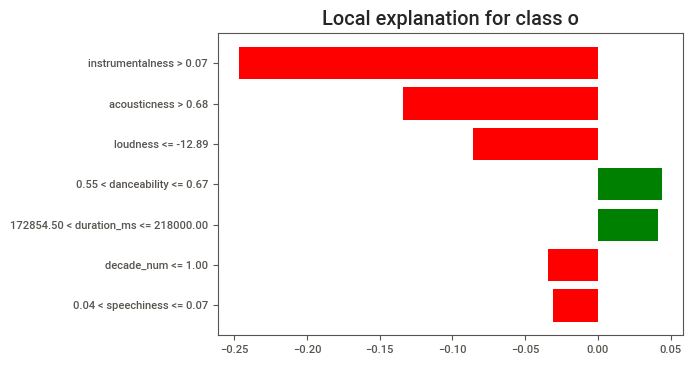

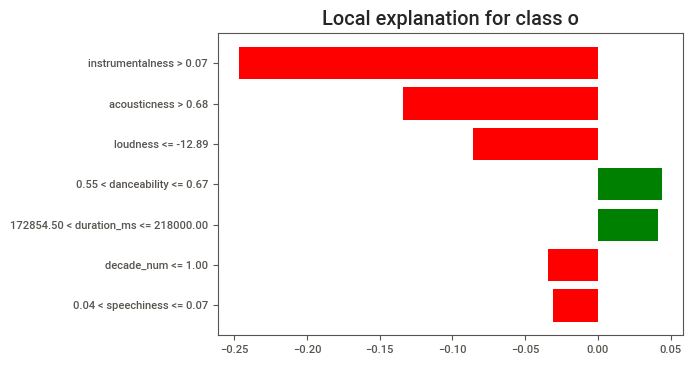

In [63]:
exp.as_pyplot_figure()

In [64]:
exp = explainer.explain_instance(X_test_np[1909], grid_rf.predict_proba, num_features = 7)

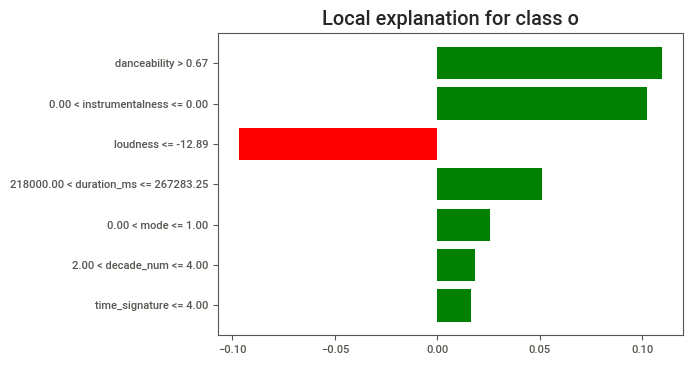

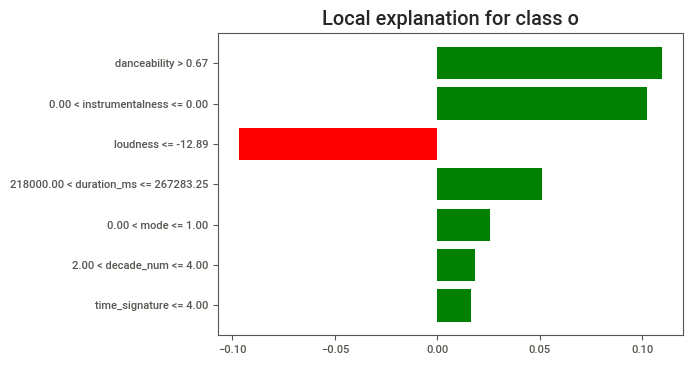

In [65]:
exp.as_pyplot_figure()

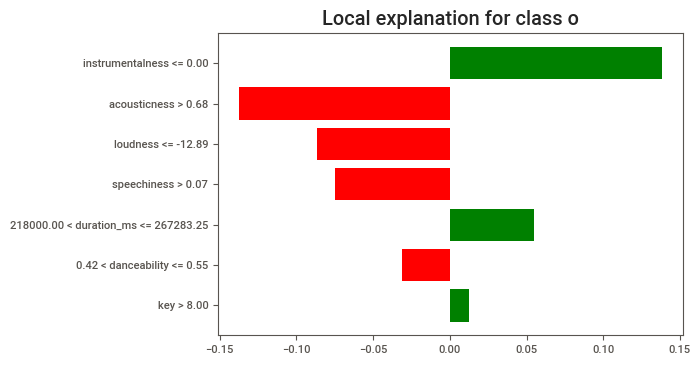

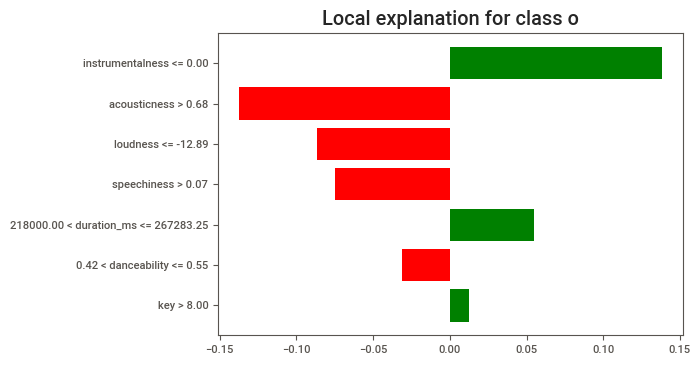

In [66]:
exp = explainer.explain_instance(X_test_np[10345], grid_rf.predict_proba, num_features = 7)
exp.as_pyplot_figure()

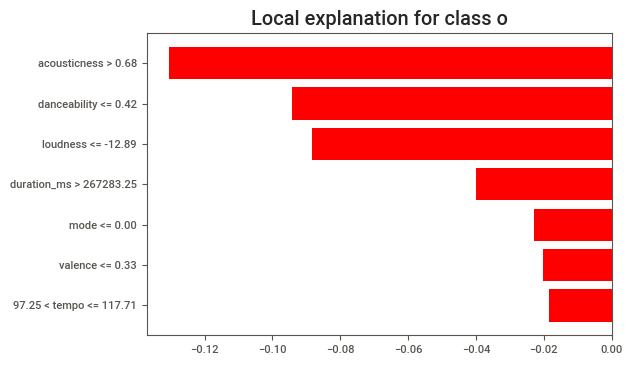

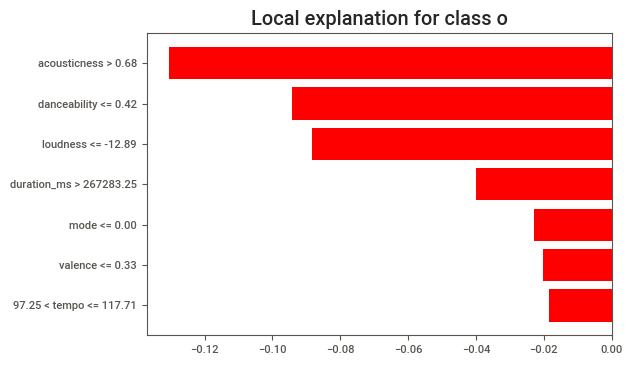

In [67]:
exp = explainer.explain_instance(X_test_np[12164], grid_rf.predict_proba, num_features = 7)
exp.as_pyplot_figure()

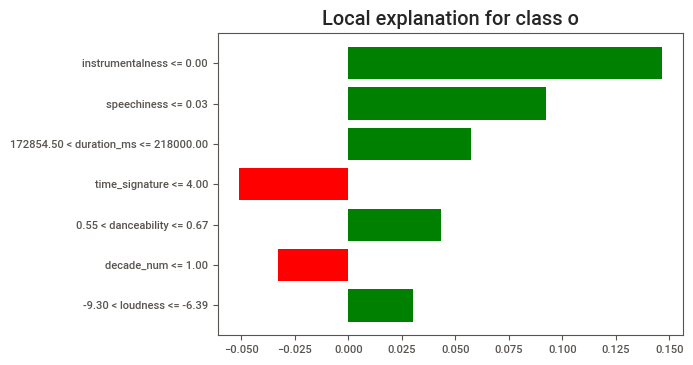

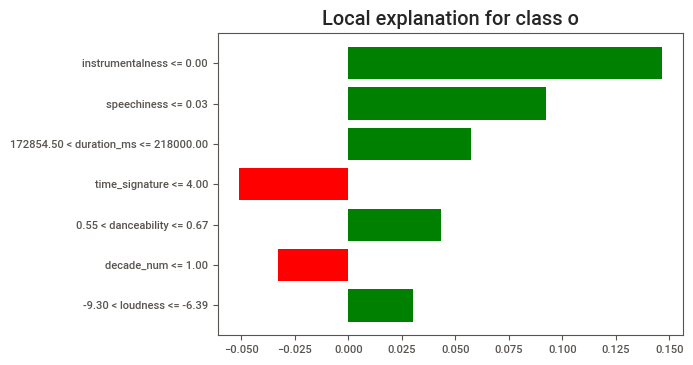

In [68]:
exp = explainer.explain_instance(X_test_np[6901], grid_rf.predict_proba, num_features = 7)
exp.as_pyplot_figure()

# Dryf modelu 

Ostatniem etapem jest sprawdzenie dryfu modelu za pomocą biblioteki Deepchecks. Regularnie przeprowadznay test pozwala na uniknięcie spadku wydajności modelu, w wyniku dryfu danych lub dryfu koncepcji, oraz ewentualne douczenie modelu.

In [69]:
cat_features = ['key', 'mode', 'time_signature', 'decade_num']
train_ds = Dataset(X_train, label=y_train, cat_features=cat_features)
test_ds = Dataset(X_test, label=y_test, cat_features=cat_features)

In [70]:
validation_suite = train_test_validation()
suite_result = validation_suite.run(train_ds, test_ds)

In [71]:
suite_result

Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_2A92PANQNFFPCUR7JR2JV525Z">Train Test Validat…

Przeprowadzony test nie wykazał zarówno zmiany koncepcji jak i zamieny relcaji między danymi wejściowymi oraz wyjściowymi.